###  Дмитрий МАРЬИН - группа dspr-58 - Car Price prediction   

#### <span style="color: LightSeaGreen;"> Юнит 7. Часть II - Проект 6. ВЫБИРАЕМ АВТО ВЫГОДНО</span>

моя страничка на GIT: https://github.com/valkoder

это **первая часть подготовка данных** - dmar_car_part_1.ipinb  
вторая часть машинное обучение - в ноутбуке dmar_car_part_1.ipinb

<a name="top"></a>  
**Навигация:**  
<a href='#task'>задача и метрика  
<a href='#par'>почему без парсинга  
<a href='#setup2'>setup  
<a href='#input'>исходные данные  
<a href='#test_check'>просмотр аттестующего (тестового) набора `df_alpha`  
<a href='#test_clean'>`df_alpha` (тест) - выводы и чистка  
<a href='#df_a_check'>просмотр обучающего `df_beta` (из all_auto_ru_09_09_2020.csv)  
<a href='#df_a_clean'>обучающий набор - `df_beta`- выводы и чистка  
<a href='#compare_df'>сравниваем форматы данных и убираем лишние столбцы и категории  
<a href='#col_sort'>сортируем столбцы  
<a href='#eda'>начало EDA  
<a href='#fields_list'>первичный список типов данных в столбцах  
<a href='#target'>целевая переменная и количественные признаки - ГРАФИКИ  
<a href='#corr'>корреляционный анализ количественных столбцов  
<a href='#corr2'>Т-тест  для категориальных признаков  
<a href='#bis'>point biserial correlation coefficient  
<a href='#eda1'>промежуточные итоги осмотра и подготовки данных  
<a href='#fe'>Feature Engineering  
<a href='#final_df'>итоговые датасеты  
<a href='#end_data'>конец EDA  
<a href='#code'>all code in one block  
<a href='#end'>END

<a name="task"></a> 
**задача** [[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price-prediction)   
Представлен контрольный набор данных без цены - **test.csv - 32 поля, 34,686 записей**  
Это подборка реальных объявлений 2020 года от продаже автомобилей с auto.ru содержащая идентификатор объявления `sell_id` и характеристики конкретного лота. Заявленная цена продажи (зависящая от характеристик авто, вменяемости продавца и от срочности продажи) отсутстствует и именно её надо предсказать.  
Для оценки результата на Kagle надо заполнить форму содержащую номера объявлений из контрольного набора и соответствующие им заявленные цены этих объявлений предсказанные на основе имеющихся характеристик с помощью обученной модели.  

Для обучение модели можно использовать данные полученные в результате самостоятельного парсинга, либо использовать данные baseline или датасеты полученные ранее другими участниками.  
**метрика в соревновании -   MAPE**   
задача - получить MAPE меньше baseline на leaderboard - 27%   
лучшие достижения на Kaggle в лидерборде = **8%**

**причины отсутствия парсинга**   
основной причиной явилась нехватка времени, особенно учитывая недавнее внедрение антипарсеров на auto.ru   
кроме того хотелось оставаться в легальном поле и не нарушать пункты 7.2.2 и 7.3 **"Пользовательского соглашение сайта AUTO.RU"** - [auto.ru Terms of Service (TOC)](https://yandex.ru/legal/autoru_terms_of_service/)  
7. Использование Сайта
    + 7.2. Пользователь обязуется при использовании Сайта:
    + 7.2.2. ... не использовать какие-либо компьютерные программы, роботы («пауки») или другие автоматические алгоритмы и методы, направленные на незаконные: «выкачивание» (сбор), передачу, копирование, блокирование, модификацию, уничтожение Информации и Базы данных, а также направленные на обход ограничений, установленных Администрацией Сайта в настройках Сайта;
    + 7.3. Без письменного разрешения Администрации Сайта Пользователь обязуется не использовать автоматические программы для получения доступа к Сайту в целях извлечения, сбора, переработки, копирования, и/или последующего распространения Информации, представленной на Сайте и/или в Базе данных.


<a name="setup2"></a> 
#### setup  

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def display_all(df):     # display many columns / raws
   with pd.option_context('display.max_rows', 6): # number of rows
      with pd.option_context('display.max_columns', 35): # columns
          display(df)

def col_info(df, col):  # records, NaN, unique, duplicates
    print("всего записей в столбце ", col, " = ", 
          df[col].count())
    print("NaN в столбце ",  col, " = ", df[col].isna().sum(), 
          ",  в процентах = ", 
          "{0:.0%}".format(df[col].isna().sum() / len(df)))
    print("уникальных в столбце ", col, " = ", 
          df[col].nunique(dropna=False))
    
    a = df[df[col].duplicated(keep=False)].count()[1]    
    print("всего записей-дубликатов в столбце ", col, " = ", a)
    
    display_all(pd.DataFrame(df[col].value_counts(sort=True, dropna=False)))

def col_info2(df1, df2, col):  # unique compare
    print("df1 - записей в столбце ", col, " = ", 
          df1[col].count())
    print("df2 - записей в столбце ", col, " = ", 
          df2[col].count())
    print("df1 - уникальных в столбце ", col, " = ", 
          df1[col].nunique(dropna=False))
    print("df2 - уникальных в столбце ", col, " = ", 
          df2[col].nunique(dropna=False))

def col_info3 (df1, df2, col):  # col statistics for two df  
    d = df1[col].describe().round(2).to_list()
    u = df1[col].nunique()
    print('df1', col, ':', u,'unique,', d[3], 'min, ',
          d[7], 'max,', d[1], 'mean,', d[0], 'rows')
    d2 = df2[col].describe().round(2).to_list()
    u2 = df2[col].nunique()
    print('df2', col, ':', u2,'unique,', d2[3], 'min, ',
          d2[7], 'max,', d2[1], 'mean,', d2[0], 'rows')
    
def nan_columns(df): # наличие пропусков в всем датафрейме
    nan_sum = df.isnull().sum()
    print('NaN fix is needed for columns:', nan_sum[nan_sum > 0], sep='\n'*2)
    
def info_table(df): # таблица NaN и unique по столбцам
    mv = df.isnull().sum()
    mvp = 100 * df.isnull().sum() / len(df)
    mv2 = df.nunique(dropna=False)
    mv_table = pd.concat([mv, mvp, mv2], axis=1)
    mv_table2 = mv_table.rename(columns = {0: 'NaN', 1: '% NaN', 2: 'uniq'})
    mv_table2 = mv_table2[mv_table2.iloc[:,1] >= 0].round(1)
    return mv_table2

def dubl(df): # наличие дубликатов записей в датафрейме
    if len(df) > len(df.drop_duplicates()):
        print('ЕСТЬ ДУБЛИКАТЫ')
        display_all(df[df.duplicated(keep=False)])
    else:
        print('дубликатов нет')

def dubl_col(df, col): # dupl find & show in specific COLUMN
    df2 = df.sort_values(by=[col]) # new dataframe sorted by col
    display_all(df2[df2[col].duplicated(keep=False)]) # show
    
def rename_columns(df): # to standart: from'S00' to 'Sxx'
    df.set_axis(["S"+str(i).zfill(2) for i in range(0, df.shape[1])], 
                 axis=1, inplace=True)
    # print(df.info())

def percentile(df, col): # перцентили, интерквартильный размах
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print(col, ': уровень 25%: {:,},'.format(perc25),
          'уровень 75%: {:,},'.format(perc75), 
          'IQR: {:,}'.format(IQR))    
def boxplot(df, col): # диаграмма размаха (boxplot)
    fig, ax = plt.subplots(figsize = (8, 0.4))
    sns.boxplot(x=col, 
                data=df.loc[
                    df.loc[:, col].isin(df.loc[
                        :, col].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title(col)
    plt.show()

<a name="input"></a> 
### исходные данные
на входе имеем:  
- `test.csv` - 34,686 записей с характеристиками авто и номером объявления `sell_id`  
- `empty_submission.csv` - 34,686 записей куда надо внести предсказанную цену
- `all_auto_ru_09_09_2020.csv` - **обучающая база с ценой**

In [3]:
# грузим входные файлы #101
df_sub = pd.read_csv('empty_submission.csv')
df_alpha = pd.read_csv('test.csv')
df_beta = pd.read_csv('all_auto_ru_09_09_2020.csv')
# названия столбцов - в нижний регистр #102
df_alpha.columns = df_alpha.columns.str.lower()
df_beta.columns = df_beta.columns.str.lower()

In [4]:
df_alpha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodytype              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34685 non-null  object
 6   enginedisplacement    34686 non-null  object
 7   enginepower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fueltype              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modeldate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [5]:
# проверим дубликаты в тесте
dubl(df_alpha)

дубликатов нет


In [6]:
# в обучающем наборе есть дубли: 3679 rows
dubl(df_beta)

ЕСТЬ ДУБЛИКАТЫ


,bodytype,brand,color,fueltype,modeldate,name,numberofdoors,productiondate,vehicleconfiguration,vehicletransmission,enginedisplacement,enginepower,description,mileage,комплектация,привод,руль,состояние,владельцы,птс,таможня,владение,price,start_date,hidden,model
37,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1992,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133.0,Продам машину целиком.Заводится.Едед.Больше го...,480000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,40000.0,2020-09-01T09:56:35Z,NaN,100
38,Седан,AUDI,0000CC,бензин,1990.0,2.3 MT (133 л.с.),4.0,1992,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133.0,Продам машину целиком.Заводится.Едед.Больше го...,480000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,40000.0,2020-09-01T09:56:35Z,NaN,100
114,Седан,AUDI,040001,бензин,1986.0,1.8 AT (90 л.с.),4.0,1990,SEDAN AUTOMATIC 1.8,AUTOMATIC,1.8,90.0,"Машина на полном ходу, автомат, люк без торга!!!",218000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,70000.0,2020-09-04T09:42:15Z,NaN,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89026,Внедорожник 5 дв.,SSANG_YONG,CACECB,дизель,2007.0,6-speed 2.0d AT (141 л.с.) 4WD,5.0,2011,ALLROAD_5_DOORS AUTOMATIC 6-speed,AUTOMATIC,6-speed,141.0,Авто в хорошем состоянии есть небольшие притёр...,68500,"{'id': '4945686', 'name': 'Comfort', 'availabl...",полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,525000.0,2020-03-24T17:53:19Z,NaN,KYRON
89253,Внедорожник 5 дв.,SSANG_YONG,200204,дизель,2006.0,2.7d MT (163 л.с.) 4WD,5.0,2009,ALLROAD_5_DOORS MECHANICAL 2.7d,MECHANICAL,2.7d,163.0,Авто в хорошем техническом состоянии. 2 - й вл...,195000,"{'id': '7864524', 'name': 'Original', 'availab...",полный,LEFT,NaN,2.0,ORIGINAL,True,NaN,524000.0,2020-08-26T08:41:57Z,NaN,REXTON
89317,Внедорожник 5 дв.,SSANG_YONG,200204,дизель,2006.0,2.7d MT (163 л.с.) 4WD,5.0,2009,ALLROAD_5_DOORS MECHANICAL 2.7d,MECHANICAL,2.7d,163.0,Авто в хорошем техническом состоянии. 2 - й вл...,195000,"{'id': '7864524', 'name': 'Original', 'availab...",полный,LEFT,NaN,2.0,ORIGINAL,True,NaN,524000.0,2020-08-26T08:41:57Z,NaN,REXTON


In [7]:
# уберем дубликаты из обучающего #103
df_beta.drop_duplicates(keep='first', inplace=True)

In [8]:
df_beta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87264 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodytype              87263 non-null  object 
 1   brand                 87264 non-null  object 
 2   color                 87264 non-null  object 
 3   fueltype              87264 non-null  object 
 4   modeldate             87263 non-null  float64
 5   name                  87263 non-null  object 
 6   numberofdoors         87263 non-null  float64
 7   productiondate        87264 non-null  int64  
 8   vehicleconfiguration  87263 non-null  object 
 9   vehicletransmission   87263 non-null  object 
 10  enginedisplacement    87263 non-null  object 
 11  enginepower           87263 non-null  float64
 12  description           84031 non-null  object 
 13  mileage               87264 non-null  int64  
 14  комплектация          87264 non-null  object 
 15  привод             

<a name="test_check"></a> 
### просмотр аттестующего набора `df_alpha`  
называю аттестующий поскольку он будет использоваться **для соревнования** Kagle  
<a href='#test_clean'>пропустить и перейти к выводам просмотра

In [9]:
# на всякий случай проверяем submission form
info_table(df_sub)

,NaN,% NaN,uniq
sell_id,0,0.0,34686
price,0,0.0,1


In [10]:
# начнем просматривать все поля - что там лежит
col_info(df_alpha, df_alpha.columns.to_list()[0])

всего записей в столбце  bodytype  =  34686
NaN в столбце  bodytype  =  0 ,  в процентах =  0%
уникальных в столбце  bodytype  =  24
всего записей-дубликатов в столбце  bodytype  =  34685


,bodytype
седан,13147
внедорожник 5 дв.,12228
лифтбек,2232
...,...
внедорожник открытый,3
тарга,2
фастбек,1


In [11]:
col_info(df_alpha, df_alpha.columns.to_list()[1])

всего записей в столбце  brand  =  34686
NaN в столбце  brand  =  0 ,  в процентах =  0%
уникальных в столбце  brand  =  12
всего записей-дубликатов в столбце  brand  =  34686


,brand
BMW,4473
VOLKSWAGEN,4404
NISSAN,4393
...,...
HONDA,1150
INFINITI,871
LEXUS,834


In [12]:
col_info(df_alpha, df_alpha.columns.to_list()[3])

всего записей в столбце  color  =  34686
NaN в столбце  color  =  0 ,  в процентах =  0%
уникальных в столбце  color  =  16
всего записей-дубликатов в столбце  color  =  34686


,color
чёрный,11010
белый,6133
серебристый,4113
...,...
жёлтый,194
оранжевый,131
розовый,13


In [13]:
col_info(df_alpha, df_alpha.columns.to_list()[4])

всего записей в столбце  complectation_dict  =  6418
NaN в столбце  complectation_dict  =  28268 ,  в процентах =  81%
уникальных в столбце  complectation_dict  =  2365
всего записей-дубликатов в столбце  complectation_dict  =  33503


complectation_dict
NaN                                                              28268
{"id":"4562904","name":"Elegance","available_op...                  51
{"id":"20913628","name":"Style","available_opti...                  26
...                                                                ...
{"id":"21436820","name":"LE Top (2018-2020)","a...                   1
{"id":"20416733","name":"SE","available_options...                   1
{"id":"6336008","name":"xDrive20d Локальная сбо...                   1

[2365 rows x 1 columns]

In [14]:
col_info(df_alpha, df_alpha.columns.to_list()[5])

всего записей в столбце  description  =  34685
NaN в столбце  description  =  1 ,  в процентах =  0%
уникальных в столбце  description  =  31729
всего записей-дубликатов в столбце  description  =  3215


,description
"Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Срочный выкуп Вашего автомобиля \n• Выкуп кредитных а/м \n• Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) \n• Выездная оценка Вашего а/м \n• Комиссионная продажа (на Ваших условиях) \n• Аукцион \n• Кредитование \n• Страхование КАСКО, ОСАГО \n• Дополнительное оборудование \n• Запасные части \n• Сервисное обслуживание \n• Б/У шины и диски",266
"РОЛЬФ - Официальный дилер и Лучший дилер России по итогам продаж и обслуживания автомобилей. Мы гарантируем Вам самые лучшие условия покупки!\n\nВсе автомобили прошли:\n\n∙ Криминалистическую и юридическую проверку.\n∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.",259
"Автодилер года 2020\n\nПобедитель в номинации «Организация продаж автомобилей с пробегом»\n\nИндивидуальные условия при покупке в кредит и/или при обмене на Ваш автомобиль.\nВсегда рады видеть Вас в нашем дилерском центре для просмотра данного автомобиля находящегося на крытой парковке ежедневно с 9 до 22. \n\nВы можете воспользоваться специальными кредитными предложениями при приобретении автомобиля: \n+ Первоначальный взнос от 0% \n+ Срок кредита от 6 месяцев до 7 лет \n+ Выгодные процентные ставки \n+ Кредит по двум документам (только паспорт и права) и выдачи кредита в автосалоне одним днем \n+ ЭКСПРЕСС автокредит, одобрение заявки и выдача автокредита за 2 часа \n+ Возможность оформления автокредита на себя, а автомобиля на другое лицо \n+ Возможность досрочного погашения на следующий день \n+ Возможность оформления в большинстве регионов РФ \n+ Возможность оформления без военного билета \n+ Возможность оформления автокредита для работающих пенсионеров (до 85 лет ) \n+ Возможность не сдавать ПТС в банк\n+ Возможность оплаты по безналичному расчёту\n\nБолее подробную информацию по комплектации, дополнительному оборудованию автомобиля и всем интересующим вопросам, уточняйте по телефону, у продавца – консультанта.",211
...,...
"✪ 1Владелец\n✪ ПТС оригинал\nВсе сертифицированные Das WeltAuto автомобили проходят квалифицированную предпродажную подготовку , которая гарантирует соответствие интерьера и экстерьера автомобиля высоким стандартам .\nПокупая данный автомобиль мы получаете дополнительны год гарантии , что минимизирует риски при покупке автомобиля с пробегом, гарантирует его высокое качество, прозрачность истории предыдущего владения и эксплуатации.\nСтав клиентом Das WeltAuto вы сможете получать профессиональную техническую поддержку 24 часа в сутки , 7 дней в неделю на территории Российской Федерации , Белоруссии , Казахстана и всех стран Евросоюза .\nБолее 250 автомобилей в наличии от Официального дилера.\nПроведена комплексная техническая диагностика.\nГарантия юридической чистоты.\nОтличное внешнее и техническое состояние.\nПолная и прозрачная история владения автомобилем.\nАвтомобиль продается от официального дилера ГК «АВТОМИР».\nДЦ «Автомир» является участником постгарантийной программы и готов предложи\n\nКомплектация:\n• Антиблокировочная система\n• Боковые передние подушки безопасности\n• Центральный замок\n• Бортовой компьютер\n• Круиз-контроль\n• Парктроник передний и задний\n• Датчик света\n• Датчик дождя\n• Гидро усилитель руля\n• Электростеклоподъемники передние\n• Электропривод зеркал\n• Климат-контроль 2-зонный\n• Подог

вероятно из 'description' можно вытащить **признак автодилера** или оптовика

In [15]:
# дублтрующиеся записи - возможно использовать как индикатор оптового продавца
# таких - 3215 записей
dubl_col(df_alpha, df_alpha.columns.to_list()[5])

,bodytype,brand,car_url,color,complectation_dict,description,enginedisplacement,enginepower,equipment_dict,fueltype,image,mileage,modeldate,model_info,model_name,name,numberofdoors,parsing_unixtime,pricecurrency,productiondate,sell_id,super_gen,vehicleconfiguration,vehicletransmission,vendor,владельцы,владение,птс,привод,руль,состояние,таможня
7042,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s60/10765...,серый,NaN,\n,2.5 LTR,210 N12,"{""airbag-rear-side"":true,""cruise-control"":true...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,340000,2000,"{""code"":""S60"",""name"":""S60"",""ru_name"":""S60"",""mo...",S60,2.5 AT (210 л.с.) 4WD,4,1603238284,RUB,2004,1076532302,"{""id"":""20885360"",""displacement"":2521,""engine_t...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
19963,седан,TOYOTA,https://auto.ru/cars/used/sale/toyota/chaser/1...,чёрный,NaN,\n,2.5 LTR,280 N12,"{""hatch"":true,""electro-mirrors"":true}",бензин,https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,130000,1994,"{""code"":""CHASER"",""name"":""Chaser"",""ru_name"":""Ча...",CHASER,2.5 AT (280 л.с.),4,1603289961,RUB,1995,1100202608,"{""id"":""8306132"",""displacement"":2491,""engine_ty...",SEDAN AUTOMATIC 2.5,автоматическая,JAPANESE,3 или более,NaN,Оригинал,задний,Правый,Не требует ремонта,Растаможен
2162,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,серый,NaN,\n,1.8 LTR,152 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,188000,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603234384,RUB,2012,1079975168,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,3 или более,5 лет и 3 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,внедорожник 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/cr_v/1101...,белый,NaN,✔У НАС КРЕДИТ ДАДУТ ВСЕМ!\n●ПРОСТО ОСТАВЬТЕ ЗА...,2.0 LTR,128 N12,"{""engine-proof"":true,""asr"":true,""adaptive-ligh...",бензин,https://autoru.naydex.net/mcQh17801/f1b5751dCi...,156000,1995,"{""code"":""CR_V"",""name"":""CR-V"",""ru_name"":""CR-V"",...",CR_V,2.0 AT (128 л.с.) 4WD,5,1603254705,RUB,1998,1101117481,"{""id"":""20501678"",""displacement"":1973,""engine_t...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,JAPANESE,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
27480,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/lanc...,серебристый,NaN,✔У НАС КРЕДИТ ДАДУТ ВСЕМ!\n●ПРОСТО ОСТАВЬТЕ ЗА...,1.6 LTR,98 N12,"{""engine-proof"":true,""cruise-control"":true,""as...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,139000,2005,"{""code"":""LANCER"",""name"":""Lancer"",""ru_name"":""Ла...",LANCER,1.6 AT (98 л.с.),4,1603262855,RUB,2006,1101130589,"{""id"":""3480641"",""displacement"":1584,""engine_ty...",SEDAN AUTOMATIC 1.6,автоматическая,JAPANESE,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
11815,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/almera/1...,бежевый,NaN,✔У НАС КРЕДИТ ДАДУТ ВСЕМ!\n●ПРОСТО ОСТАВЬТЕ ЗА...,1.5 LTR,98 N12,"{""engine-proof"":true,""asr"":true,""airbag-driver...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,144000,2002,"{""code"":""ALMERA"",""name"":""Almera"",""ru_name"":""Ал...",ALMERA,1.5 MT (98 л.с.),4,1603272280,RUB,2005,1101151810,"{""id"":""4602027"",""displacement"":1497,""engine_ty...",SEDAN MECHANICAL 1.5,механическая,JAPANESE,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [16]:
# найдем число оптовых продавцов (магазинов) = 258 unique
df3 = df_alpha[df_alpha['description'].duplicated(keep=False)]
col_info(df3, df3.columns.to_list()[5])

всего записей в столбце  description  =  3215
NaN в столбце  description  =  0 ,  в процентах =  0%
уникальных в столбце  description  =  258
всего записей-дубликатов в столбце  description  =  3215


,description
"Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Срочный выкуп Вашего автомобиля \n• Выкуп кредитных а/м \n• Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) \n• Выездная оценка Вашего а/м \n• Комиссионная продажа (на Ваших условиях) \n• Аукцион \n• Кредитование \n• Страхование КАСКО, ОСАГО \n• Дополнительное оборудование \n• Запасные части \n• Сервисное обслуживание \n• Б/У шины и диски",266
"РОЛЬФ - Официальный дилер и Лучший дилер России по итогам продаж и обслуживания автомобилей. Мы гарантируем Вам самые лучшие условия покупки!\n\nВсе автомобили прошли:\n\n∙ Криминалистическую и юридическую проверку.\n∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.",259
"Автодилер года 2020\n\nПобедитель в номинации «Организация продаж автомобилей с пробегом»\n\nИндивидуальные условия при покупке в кредит и/или при обмене на Ваш автомобиль.\nВсегда рады видеть Вас в нашем дилерском центре для просмотра данного автомобиля находящегося на крытой парковке ежедневно с 9 до 22. \n\nВы можете воспользоваться специальными кредитными предложениями при приобретении автомобиля: \n+ Первоначальный взнос от 0% \n+ Срок кредита от 6 месяцев до 7 лет \n+ Выгодные процентные ставки \n+ Кредит по двум документам (только паспорт и права) и выдачи кредита в автосалоне одним днем \n+ ЭКСПРЕСС автокредит, одобрение заявки и выдача автокредита за 2 часа \n+ Возможность оформления автокредита на себя, а автомобиля на другое лицо \n+ Возможность досрочного погашения на следующий день \n+ Возможность оформления в большинстве регионов РФ \n+ Возможность оформления без военного билета \n+ Возможность оформления автокредита для работающих пенсионеров (до 85 лет ) \n+ Возможность не сдавать ПТС в банк\n+ Возможность оплаты по безналичному расчёту\n\nБолее подробную информацию по комплектации, дополнительному оборудованию автомобиля и всем интересующим вопросам, уточняйте по телефону, у продавца – консультанта.",211
...,...
"При покупке автомобиля с пробегом в КРЕДИТ предоставляется СКИДКА в размере 30 000 руб.\n\nДанный автомобиль представлен в нашем автосалоне!\n\nПриобретая автомобиль у нас, Вы получаете гарантию высокой надежности сделки при покупке и Гарантию на приобретаемый автомобиль! Гарантия юридической чистоты 100% - каждый автомобиль предварительно проверяется при приеме нашей службой безопасности по всем базам.\n\n* Автомобиль в отличном состоянии, на автомобиле проведена полная предпродажная подготовка, вложений не требует.\n\n* Лакокрасочное покрытие без повреждений.\n\n* Коробка и двигатель работают без нареканий (предоставляется 1 год гарантии).\n\n* Салон чистый, не прокуренный, ПТС оригинал.\n\n* Второй комплект ключей и сервисная книжка в наличии.\n\nЕсли Вы уже получили предложение от другого дилера-позвоните нам, и мы постараемся его улучшить!\n\nВыдача автомобиля в день обращения, независимо от формы оплаты (безналичный расчет, кредит, наличный расчет, оплата по банковской карте).",2
"Авто в отличном состоянии моторо коробка без нареканий, ходовая тоже отличная, подогрев сидении, есть кондер мощный, музыка, машина просто сел и поехал, пробег родной, продаю из за покупки нового авто.",2
"Автомобильная группа Автоград покупает и продает исключительно надежные и проверенные автомобили с пробегом. Мы дорожим личным времен

In [17]:
# пустых (LTR без числа) в engineDisplacement  =  55
col_info(df_alpha, df_alpha.columns.to_list()[6])

всего записей в столбце  enginedisplacement  =  34686
NaN в столбце  enginedisplacement  =  0 ,  в процентах =  0%
уникальных в столбце  enginedisplacement  =  55
всего записей-дубликатов в столбце  enginedisplacement  =  34684


,enginedisplacement
2.0 LTR,7391
1.6 LTR,4973
3.0 LTR,3915
...,...
1.1 LTR,4
3.9 LTR,1
5.3 LTR,1


In [18]:
col_info(df_alpha, df_alpha.columns.to_list()[7])

всего записей в столбце  enginepower  =  34686
NaN в столбце  enginepower  =  0 ,  в процентах =  0%
уникальных в столбце  enginepower  =  315
всего записей-дубликатов в столбце  enginepower  =  34655


,enginepower
249 N12,1708
150 N12,1699
110 N12,1039
...,...
38 N12,1
32 N12,1
301 N12,1


In [19]:
col_info(df_alpha, df_alpha.columns.to_list()[8])

всего записей в столбце  equipment_dict  =  24690
NaN в столбце  equipment_dict  =  9996 ,  в процентах =  29%
уникальных в столбце  equipment_dict  =  23706
всего записей-дубликатов в столбце  equipment_dict  =  11336


,equipment_dict
NaN,9996
"{""leather"":true}",108
"{""gbo"":true}",106
...,...
"{""cruise-control"":true,""asr"":true,""tinted-glass"":true,""esp"":true,""usb"":true,""multi-wheel"":true,""spare-wheel"":true,""audiosystem-tv"":true,""airbag-passenger"":true,""front-centre-armrest"":true,""navigation"":true,""apple-carplay"":true,""front-seat-support"":true,""bas"":true,""lock"":true,""rear-camera"":true,""drl"":true,""electro-mirrors"":true,""electro-window-back"":true,""easy-trunk-opening"":true,""mirrors-heat"":true,""17-inch-wheels"":true,""park-assist-f"":true,""wheel-heat"":true,""park-assist-r"":true,""glonass"":true,""airbag-driver"":true,""aux"":true,""isofix"":true,""electro-window-front"":true,""light-sensor"":true,""hcc"":true,""airbag-curtain"":true,""passenger-seat-updown"":true,""computer"":true,""keyless-entry"":true,""ya-auto"":true,""seat-transformation"":true,""android-auto"":true,""wheel-power"":true,""dha"":true,""fabric-seats"":true,""ptf"":true,""leather-gear-stick"":true,""start-button"":true,""rain-sensor"":true,""airbag-side"":true,""electro-trunk"":true,""abs"":true,""bluetooth"":true,""front-seats-heat"":true,""wheel-leather"":true,""wheel-configuration2"":true,""wheel-configuration1"":true,""immo"":true,""windscreen-heat"":true,""climate-control-2"":true,""auto-mirrors"":true,""12v-socket"":true,""third-rear-headrest"":true}",1
"{""front-seats-heat"":true,""wheel-power"":true,""fabric-seats"":true}",1
"{""alloy-wheel-disks"":true,""navigation"":true,""ptf"":true,""airbrush"":true,""aux"":true,""20-inch-wheels"":true,""dark-interior"":true,""xenon"":true,""leather"":true,""seat-memory"":true}",1


In [20]:
col_info(df_alpha, df_alpha.columns.to_list()[9])

всего записей в столбце  fueltype  =  34686
NaN в столбце  fueltype  =  0 ,  в процентах =  0%
уникальных в столбце  fueltype  =  5
всего записей-дубликатов в столбце  fueltype  =  34686


,fueltype
бензин,28601
дизель,5800
гибрид,223
электро,55
газ,7


In [21]:
#  ссылки на фото
col_info(df_alpha, df_alpha.columns.to_list()[10])

всего записей в столбце  image  =  34686
NaN в столбце  image  =  0 ,  в процентах =  0%
уникальных в столбце  image  =  34557
всего записей-дубликатов в столбце  image  =  183


,image
https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr,13
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr,9
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d6c09eb305345ee1ea7e7bd15/wizardv3mr,8
...,...
https://avatars.mds.yandex.net/get-autoru-vos/2028593/413fc7d3c52e136e34499dee00eb91ad/320x240,1
https://autoru.naydex.net/G87gDZg56/28c7a8vqVE/xGtzQkxaH-LvfLMYcqnNjeKZWSgfkOxAh1jWB0acClC2yBpE7d1cW7XQArDH8gkwstoQKtHhIKg58J8hAuHkUYMre1kHCw_grCvwXm6mnsyo1Q5pSMekFtsJknd-uD8_iPI8YtjhP0yv10KshLFkX6KPZQiHwCXaXtjiRHK-lQ#DSD,1
https://avatars.mds.yandex.net/get-autoru-vos/2159583/a3610c94aebcc8d6b441ca84222ce095/320x240,1


In [22]:
col_info(df_alpha, df_alpha.columns.to_list()[11])

всего записей в столбце  mileage  =  34686
NaN в столбце  mileage  =  0 ,  в процентах =  0%
уникальных в столбце  mileage  =  11268
всего записей-дубликатов в столбце  mileage  =  24887


,mileage
200000,436
150000,382
300000,381
...,...
210311,1
121363,1
157965,1


In [23]:
col_info(df_alpha, df_alpha.columns.to_list()[12])

всего записей в столбце  modeldate  =  34686
NaN в столбце  modeldate  =  0 ,  в процентах =  0%
уникальных в столбце  modeldate  =  66
всего записей-дубликатов в столбце  modeldate  =  34679


,modeldate
2010,2503
2013,2275
2008,2243
...,...
1969,1
1934,1
1960,1


In [24]:
col_info(df_alpha, df_alpha.columns.to_list()[13])

всего записей в столбце  model_info  =  34686
NaN в столбце  model_info  =  0 ,  в процентах =  0%
уникальных в столбце  model_info  =  954
всего записей-дубликатов в столбце  model_info  =  34527


,model_info
"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""Октавия"",""morphology"":{""gender"":""FEMININE""},""nameplate"":{""code"":"""",""name"":"""",""semantic_url"":""""}}",1404
"{""code"":""LANCER"",""name"":""Lancer"",""ru_name"":""Лансер"",""morphology"":{},""nameplate"":{""code"":"""",""name"":"""",""semantic_url"":""""}}",843
"{""code"":""PASSAT"",""name"":""Passat"",""ru_name"":""Пассат"",""morphology"":{},""nameplate"":{""code"":"""",""name"":"""",""semantic_url"":""""}}",776
...,...
"{""code"":""M_KLASSE"",""name"":""M-Класс"",""ru_name"":""M-класс"",""morphology"":{},""nameplate"":{""code"":""9264723"",""name"":""230"",""semantic_url"":""230""}}",1
"{""code"":""S_KLASSE"",""name"":""S-Класс"",""ru_name"":""S-класс"",""morphology"":{},""nameplate"":{""code"":""11903228"",""name"":""420 L"",""semantic_url"":""420_l""}}",1
"{""code"":""LAND_CRUISER_PRADO"",""name"":""Land Cruiser Prado"",""ru_name"":""Ленд Крузер Прадо"",""morphology"":{},""nameplate"":{""code"":""11880760"",""name"":""Arctic Trucks"",""semantic_url"":""arctic_trucks""}}",1


In [25]:
col_info(df_alpha, df_alpha.columns.to_list()[14])

всего записей в столбце  model_name  =  34686
NaN в столбце  model_name  =  0 ,  в процентах =  0%
уникальных в столбце  model_name  =  544
всего записей-дубликатов в столбце  model_name  =  34603


,model_name
OCTAVIA,1418
5ER,1026
LANCER,855
...,...
VERSO_S,1
Z3M,1
PLATZ,1


In [26]:
col_info(df_alpha, df_alpha.columns.to_list()[15])

всего записей в столбце  name  =  34686
NaN в столбце  name  =  0 ,  в процентах =  0%
уникальных в столбце  name  =  2780
всего записей-дубликатов в столбце  name  =  33834


,name
1.6 AT (110 л.с.),631
1.6 MT (102 л.с.),410
1.6 MT (110 л.с.),314
...,...
3.5d MT (115 л.с.) 4WD,1
3.0 AT (223 л.с.),1
300 3.0 AT (218 л.с.),1


In [27]:
col_info(df_alpha, df_alpha.columns.to_list()[16])

всего записей в столбце  numberofdoors  =  34686
NaN в столбце  numberofdoors  =  0 ,  в процентах =  0%
уникальных в столбце  numberofdoors  =  5
всего записей-дубликатов в столбце  numberofdoors  =  34685


,numberofdoors
5,18703
4,14126
2,1206
3,650
0,1


In [28]:
# parsing_unixtime convert to date
df_alpha.parsing_unixtime = pd.to_datetime(
    df_alpha.parsing_unixtime, unit='s')
print(df_alpha.parsing_unixtime.min())
print(df_alpha.parsing_unixtime.max())

2020-10-19 11:35:06
2020-10-26 11:04:24


In [29]:
col_info(df_alpha, df_alpha.columns.to_list()[17])

всего записей в столбце  parsing_unixtime  =  34686
NaN в столбце  parsing_unixtime  =  0 ,  в процентах =  0%
уникальных в столбце  parsing_unixtime  =  34686
всего записей-дубликатов в столбце  parsing_unixtime  =  0


,parsing_unixtime
2020-10-20 20:37:53,1
2020-10-21 17:38:56,1
2020-10-21 17:39:48,1
...,...
2020-10-21 09:07:53,1
2020-10-21 09:07:50,1
2020-10-26 11:04:24,1


In [30]:
col_info(df_alpha, df_alpha.columns.to_list()[19])

всего записей в столбце  productiondate  =  34686
NaN в столбце  productiondate  =  0 ,  в процентах =  0%
уникальных в столбце  productiondate  =  69
всего записей-дубликатов в столбце  productiondate  =  34670


,productiondate
2012,2798
2008,2606
2011,2589
...,...
1968,1
1939,1
1948,1


In [31]:
col_info(df_alpha, df_alpha.columns.to_list()[20])

всего записей в столбце  sell_id  =  34686
NaN в столбце  sell_id  =  0 ,  в процентах =  0%
уникальных в столбце  sell_id  =  34686
всего записей-дубликатов в столбце  sell_id  =  0


,sell_id
1100575026,1
1099652342,1
1096320100,1
...,...
1100848942,1
1101080459,1
1101256068,1


In [32]:
col_info(df_alpha, df_alpha.columns.to_list()[21])

всего записей в столбце  super_gen  =  34686
NaN в столбце  super_gen  =  0 ,  в процентах =  0%
уникальных в столбце  super_gen  =  5890
всего записей-дубликатов в столбце  super_gen  =  32202


,super_gen
"{""id"":""6214876"",""displacement"":1598,""engine_type"":""GASOLINE"",""gear_type"":""FORWARD_CONTROL"",""transmission"":""MECHANICAL"",""power"":105,""power_kvt"":77,""human_name"":""1.6 MT (105 л.с.)"",""acceleration"":10.5,""clearance_min"":170,""fuel_rate"":6.5}",193
"{""id"":""20726520"",""displacement"":1598,""engine_type"":""GASOLINE"",""gear_type"":""FORWARD_CONTROL"",""transmission"":""AUTOMATIC"",""power"":110,""power_kvt"":81,""human_name"":""1.6 AT (110 л.с.)"",""acceleration"":11.7,""clearance_min"":163,""fuel_rate"":5.9}",159
"{""id"":""4561004"",""displacement"":1798,""engine_type"":""GASOLINE"",""gear_type"":""FORWARD_CONTROL"",""transmission"":""AUTOMATIC"",""power"":152,""power_kvt"":112,""human_name"":""1.8 AT (152 л.с.)"",""acceleration"":8.8,""clearance_min"":164,""fuel_rate"":7.7}",148
...,...
"{""id"":""20399174"",""displacement"":1299,""engine_type"":""GASOLINE"",""gear_type"":""FORWARD_CONTROL"",""transmission"":""AUTOMATIC"",""power"":86,""power_kvt"":63,""human_name"":""1.3 AT (86 л.с.)"",""clearance_min"":150}",1
"{""id"":""21814305"",""displacement"":2362,""engine_type"":""GASOLINE"",""gear_type"":""ALL_WHEEL_DRIVE"",""transmission"":""VARIATOR"",""power"":170,""power_kvt"":125,""human_name"":""2.4 CVT (170 л.с.) 4WD"",""clearance_min"":191}",1
"{""id"":""2305530"",""name"":""130"",""nameplate"":""130i"",""displacement"":2996,""engine_type"":""GASOLINE"",""gear_type"":""REAR_DRIVE"",""transmission"":""AUTOMATIC"",""power"":265,""power_kvt"":195,""human_name"":""130i 3.0 AT (265 л.с.)"",""acceleration"":6.3,""clearance_min"":145,""fuel_rate"":9.2}",1


In [33]:
col_info(df_alpha, df_alpha.columns.to_list()[22])

всего записей в столбце  vehicleconfiguration  =  34686
NaN в столбце  vehicleconfiguration  =  0 ,  в процентах =  0%
уникальных в столбце  vehicleconfiguration  =  634
всего записей-дубликатов в столбце  vehicleconfiguration  =  34570


,vehicleconfiguration
ALLROAD_5_DOORS AUTOMATIC 3.0,2389
SEDAN AUTOMATIC 2.0,1610
ALLROAD_5_DOORS AUTOMATIC 2.0,1327
...,...
ALLROAD_3_DOORS MECHANICAL 4.2,1
FASTBACK MECHANICAL 2.8,1
ALLROAD_OPEN AUTOMATIC 2.0,1


In [34]:
col_info(df_alpha, df_alpha.columns.to_list()[23])

всего записей в столбце  vehicletransmission  =  34686
NaN в столбце  vehicletransmission  =  0 ,  в процентах =  0%
уникальных в столбце  vehicletransmission  =  4
всего записей-дубликатов в столбце  vehicletransmission  =  34686


,vehicletransmission
автоматическая,19596
механическая,7209
вариатор,3999
роботизированная,3882


In [35]:
col_info(df_alpha, df_alpha.columns.to_list()[24])

всего записей в столбце  vendor  =  34686
NaN в столбце  vendor  =  0 ,  в процентах =  0%
уникальных в столбце  vendor  =  2
всего записей-дубликатов в столбце  vendor  =  34686


,vendor
EUROPEAN,20682
JAPANESE,14004


In [36]:
col_info(df_alpha, df_alpha.columns.to_list()[25])

всего записей в столбце  владельцы  =  34686
NaN в столбце  владельцы  =  0 ,  в процентах =  0%
уникальных в столбце  владельцы  =  3
всего записей-дубликатов в столбце  владельцы  =  34686


,владельцы
3 или более,15957
1 владелец,9459
2 владельца,9270


In [37]:
col_info(df_alpha, df_alpha.columns.to_list()[26])

всего записей в столбце  владение  =  11995
NaN в столбце  владение  =  22691 ,  в процентах =  65%
уникальных в столбце  владение  =  276
всего записей-дубликатов в столбце  владение  =  34647


,владение
NaN,22691
1 год и 10 месяцев,209
2 года,197
...,...
34 года и 2 месяца,1
28 лет и 8 месяцев,1
22 года и 9 месяцев,1


In [38]:
col_info(df_alpha, df_alpha.columns.to_list()[27])

всего записей в столбце  птс  =  34685
NaN в столбце  птс  =  1 ,  в процентах =  0%
уникальных в столбце  птс  =  3
всего записей-дубликатов в столбце  птс  =  34685


,птс
Оригинал,30098
Дубликат,4587
NaN,1


In [39]:
col_info(df_alpha, df_alpha.columns.to_list()[28])

всего записей в столбце  привод  =  34686
NaN в столбце  привод  =  0 ,  в процентах =  0%
уникальных в столбце  привод  =  3
всего записей-дубликатов в столбце  привод  =  34686


,привод
передний,15565
полный,15020
задний,4101


In [40]:
col_info(df_alpha, df_alpha.columns.to_list()[29])

всего записей в столбце  руль  =  34686
NaN в столбце  руль  =  0 ,  в процентах =  0%
уникальных в столбце  руль  =  2
всего записей-дубликатов в столбце  руль  =  34686


,руль
Левый,33287
Правый,1399


In [41]:
col_info(df_alpha, df_alpha.columns.to_list()[30])

всего записей в столбце  состояние  =  34686
NaN в столбце  состояние  =  0 ,  в процентах =  0%
уникальных в столбце  состояние  =  1
всего записей-дубликатов в столбце  состояние  =  34686


,состояние
Не требует ремонта,34686


In [42]:
col_info(df_alpha, df_alpha.columns.to_list()[31])

всего записей в столбце  таможня  =  34686
NaN в столбце  таможня  =  0 ,  в процентах =  0%
уникальных в столбце  таможня  =  1
всего записей-дубликатов в столбце  таможня  =  34686


,таможня
Растаможен,34686


#### обзор аттестующего датасета `df_alpha`

In [43]:
info_table(df_alpha) # обзор датасета

,NaN,% NaN,uniq
bodytype,0,0.0,24
brand,0,0.0,12
car_url,0,0.0,34686
color,0,0.0,16
complectation_dict,28268,81.5,2365
description,1,0.0,31729
enginedisplacement,0,0.0,55
enginepower,0,0.0,315
equipment_dict,9996,28.8,23706
fueltype,0,0.0,5


<a name="test_clean"></a> 
### аттестующий датасет `df_alpha` - выводы и чистка
поля:
- `0 bodyType` - keep
- `1 brand` - keep
- `2 car_url` - дубль `sell_id` - **del**
- `4 complectation_dict` - 28% NaN, индикатор автосалона - **del**
- `5 description` - при оценке дубликотов найдено 3215 записей от 258 авто-магазинов, используем как признак оптового продавца - keep
- `6 engineDisplacement` - keep, надо разбирать 
some values contain 'LTR', some do not > remove 'LTR' and convert column from categorical to floats; пустых (LTR без числа) в engineDisplacement  =  55шт
- `7 enginePower` - keep
- `8 equipment_dict` - 30% пропусков, видимо комплектация от дилера - **del**
- `9 fuelType` - keep, надо разбирать
- `10 image` - ссылки на фото - **del**
- `11 mileage` - keep, ready to use
- `12 modelDate` - keep, ready to use
- `13 model_info` - keep, надо разбирать
- `14 model_name` - keep, надо разбирать
- `15 name` - keep, объем и мощность, надо разбирать
- `16 numberOfDoors` - keep, непонятен принцип счета
- `17 parsing_unixtime` = Oct 2020 - **del**
- `18 priceCurrency` - **del**
- `19 productionDate`- keep, ready to use
- `20 sell_id` - keep, key index for submission
- `21 super_gen` - keep, надо разбирать
- `22 vehicleConfiguration` - keep, надо разбирать
- `23 vehicleTransmission` - keep, ready to use
- `24 vendor` - keep, ready to use (EUR/Japan)
- `25 Владельцы` - keep, ready to use (after transform)
- `26 Владение` - **del** (65% NaN)
- `27 ПТС` - keep, ready to use (1 NaN to replace)
- `28 Привод` - keep, ready to use
- `29 Руль` - keep, ready to use
- `30 Состояние` - **del**
- `31 Таможня` - **del**

Итого **удаляем 8 полей**: `[2, 4, 8, 10, 17, 18, 26, 30, 31]`

In [44]:
# df_alpha - удаляем 8 полей #104
df_alpha.drop(df_alpha.columns[[2, 4, 8, 10, 17, 18, 26, 30, 31]], 
              axis = 1, inplace = True)

In [45]:
df_alpha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodytype              34686 non-null  object
 1   brand                 34686 non-null  object
 2   color                 34686 non-null  object
 3   description           34685 non-null  object
 4   enginedisplacement    34686 non-null  object
 5   enginepower           34686 non-null  object
 6   fueltype              34686 non-null  object
 7   mileage               34686 non-null  int64 
 8   modeldate             34686 non-null  int64 
 9   model_info            34686 non-null  object
 10  model_name            34686 non-null  object
 11  name                  34686 non-null  object
 12  numberofdoors         34686 non-null  int64 
 13  productiondate        34686 non-null  int64 
 14  sell_id               34686 non-null  int64 
 15  super_gen             34686 non-null

In [46]:
info_table(df_alpha) # обзор датасета

,NaN,% NaN,uniq
bodytype,0,0.0,24
brand,0,0.0,12
color,0,0.0,16
description,1,0.0,31729
enginedisplacement,0,0.0,55
enginepower,0,0.0,315
fueltype,0,0.0,5
mileage,0,0.0,11268
modeldate,0,0.0,66
model_info,0,0.0,954


всего 2 пропуска - 1 один в 'description и один в 'ПТС'

<a name="df_a_check"></a> 
### просмотр обучающего набора `df_beta`
созданного из `all_auto_ru_09_09_2020.csv`  
<a href='#df_a_clean'>сразу перейти к выводам просмотра

In [47]:
# начнем просматривать все поля - что там лежит
# названия начинаются с заглавной буквы - поправить
col_info(df_beta, df_beta.columns.to_list()[0])

всего записей в столбце  bodytype  =  87263
NaN в столбце  bodytype  =  1 ,  в процентах =  0%
уникальных в столбце  bodytype  =  169
всего записей-дубликатов в столбце  bodytype  =  87230


,bodytype
Внедорожник 5 дв.,30712
Седан,30055
Хэтчбек 5 дв.,8616
...,...
NaN,1
Универсал 5 дв. Shuttle,1
Минивэн Regius,1


In [48]:
col_info(df_beta, df_beta.columns.to_list()[1])

всего записей в столбце  brand  =  87264
NaN в столбце  brand  =  0 ,  в процентах =  0%
уникальных в столбце  brand  =  36
всего записей-дубликатов в столбце  brand  =  87264


,brand
MERCEDES,7716
BMW,7125
VOLKSWAGEN,6976
...,...
JAGUAR,308
MINI,305
GEELY,272


In [49]:
col_info(df_beta, df_beta.columns.to_list()[2])

всего записей в столбце  color  =  87264
NaN в столбце  color  =  0 ,  в процентах =  0%
уникальных в столбце  color  =  16
всего записей-дубликатов в столбце  color  =  87264


,color
040001,24458
FAFBFB,15300
CACECB,11171
...,...
4A2197,602
FF8649,505
FFC0CB,25


In [50]:
col_info(df_beta, df_beta.columns.to_list()[3])

всего записей в столбце  fueltype  =  87264
NaN в столбце  fueltype  =  0 ,  в процентах =  0%
уникальных в столбце  fueltype  =  6
всего записей-дубликатов в столбце  fueltype  =  87263


,fueltype
бензин,73365
дизель,13487
гибрид,291
электро,109
газ,11
универсал,1


In [51]:
# проверим что такое "универсал" в графе "топливо"
df4 = df_beta[df_beta.fueltype.str.contains('универсал')]
display_all(df4)

,bodytype,brand,color,fueltype,modeldate,name,numberofdoors,productiondate,vehicleconfiguration,vehicletransmission,enginedisplacement,enginepower,description,mileage,комплектация,привод,руль,состояние,владельцы,птс,таможня,владение,price,start_date,hidden,model
24624,NaN,HONDA,CACECB,универсал,NaN,NaN,NaN,1989,NaN,NaN,NaN,NaN,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",400000,"{'id': '0', 'name': ''}",NaN,LEFT,NaN,3.0,ORIGINAL,True,NaN,120000.0,2020-04-10T16:07:57Z,NaN,CIVIC


In [52]:
# df_beta - удалим строку "универсал" в столбце 'fueltype' #104
df_beta.drop(df_beta[df_beta.fueltype == 'универсал'].index, inplace=True)
df_beta = df_beta.reset_index(drop=True)

In [53]:
col_info(df_beta, 'fueltype')

всего записей в столбце  fueltype  =  87263
NaN в столбце  fueltype  =  0 ,  в процентах =  0%
уникальных в столбце  fueltype  =  5
всего записей-дубликатов в столбце  fueltype  =  87263


,fueltype
бензин,73365
дизель,13487
гибрид,291
электро,109
газ,11


In [54]:
col_info(df_beta, df_beta.columns.to_list()[4])

всего записей в столбце  modeldate  =  87263
NaN в столбце  modeldate  =  0 ,  в процентах =  0%
уникальных в столбце  modeldate  =  78
всего записей-дубликатов в столбце  modeldate  =  87256


,modeldate
2006.0,6101
2010.0,5866
2009.0,5662
...,...
1950.0,1
1904.0,1
1948.0,1


In [55]:
col_info(df_beta, df_beta.columns.to_list()[5])

всего записей в столбце  name  =  87263
NaN в столбце  name  =  0 ,  в процентах =  0%
уникальных в столбце  name  =  4484
всего записей-дубликатов в столбце  name  =  85947


,name
2.0 AT (150 л.с.),1568
1.6 AT (123 л.с.),1297
1.6 AT (110 л.с.),1090
...,...
2.0 MT (245 л.с.),1
4.1d AT (155 л.с.) 4WD,1
StreetKa 1.6 MT (95 л.с.),1


In [56]:
col_info(df_beta, df_beta.columns.to_list()[6])

всего записей в столбце  numberofdoors  =  87263
NaN в столбце  numberofdoors  =  0 ,  в процентах =  0%
уникальных в столбце  numberofdoors  =  5
всего записей-дубликатов в столбце  numberofdoors  =  87262


,numberofdoors
5.0,50208
4.0,32980
3.0,2197
2.0,1877
0.0,1


In [57]:
col_info(df_beta, df_beta.columns.to_list()[7])

всего записей в столбце  productiondate  =  87263
NaN в столбце  productiondate  =  0 ,  в процентах =  0%
уникальных в столбце  productiondate  =  80
всего записей-дубликатов в столбце  productiondate  =  87247


,productiondate
2020,11126
2008,6995
2012,6580
...,...
1971,1
1931,1
1949,1


In [58]:
col_info(df_beta, df_beta.columns.to_list()[8])

всего записей в столбце  vehicleconfiguration  =  87263
NaN в столбце  vehicleconfiguration  =  0 ,  в процентах =  0%
уникальных в столбце  vehicleconfiguration  =  1860
всего записей-дубликатов в столбце  vehicleconfiguration  =  86800


,vehicleconfiguration
SEDAN MECHANICAL 1.6,4130
SEDAN AUTOMATIC 1.6,3519
ALLROAD_5_DOORS VARIATOR 2.0,2762
...,...
SEDAN AUTOMATIC 7.0,1
CABRIO AUTOMATIC 8.2,1
HATCHBACK_3_DOORS VARIATOR Hybrid,1


In [59]:
col_info(df_beta, df_beta.columns.to_list()[9])

всего записей в столбце  vehicletransmission  =  87263
NaN в столбце  vehicletransmission  =  0 ,  в процентах =  0%
уникальных в столбце  vehicletransmission  =  4
всего записей-дубликатов в столбце  vehicletransmission  =  87263


,vehicletransmission
AUTOMATIC,48029
MECHANICAL,25075
ROBOT,7550
VARIATOR,6609


In [60]:
col_info(df_beta, df_beta.columns.to_list()[10])

всего записей в столбце  enginedisplacement  =  87263
NaN в столбце  enginedisplacement  =  0 ,  в процентах =  0%
уникальных в столбце  enginedisplacement  =  534
всего записей-дубликатов в столбце  enginedisplacement  =  87178


,enginedisplacement
1.6,16722
2.0,12867
1.4,5549
...,...
PowerShift,1
Shuttle,1
6.7d,1


In [61]:
col_info(df_beta, df_beta.columns.to_list()[11])

всего записей в столбце  enginepower  =  87263
NaN в столбце  enginepower  =  0 ,  в процентах =  0%
уникальных в столбце  enginepower  =  396
всего записей-дубликатов в столбце  enginepower  =  87234


,enginepower
150.0,6854
249.0,3485
140.0,2852
...,...
236.0,1
437.0,1
591.0,1


In [62]:
col_info(df_beta, df_beta.columns.to_list()[12])

всего записей в столбце  description  =  84030
NaN в столбце  description  =  3233 ,  в процентах =  4%
уникальных в столбце  description  =  77568
всего записей-дубликатов в столбце  description  =  11390


,description
NaN,3233
"РОЛЬФ Северо-Запад - это первый мегамолл автомобилей с пробегом, где на площади 27 000 кв.м. вас ждут 1 500 автомобилей с комфортными условиями покупки и выгодными предложениями.· Все автомобили проверены по стандартам РОЛЬФ и заводов-изготовителей· Более 50 брендов в различных ценовых категориях· Возможность приобретения выбранного автомобиля в кредит (более 10 Банков-партнеров: ЮниКредитБанк, Экспо Банк, Тинькофф Банк, Совкомбанк, Сетелем, Русфинанс Банк, Росгосстрах банк, МС Банк, Локо Банк ,Кредит Европа Банк, ВТБ, Банк УРАЛСИБ, Банк Союз, Банк Зенит, Балтинвестбанк).· Любые виды страхования автомобилей· Услуги ГИБДД (поставка на учет, прекращение учета, сохранение государственных знаков)· Гарантия юридической чистоты и безопасность сделки· Гарантия на автомобили различных марок сроком до 24 месяцев при общем пробеге до 200 000 кмДля Вашего удобства:• Онлайн-консультация по интересующему вас автомобилю.• Онлайн-бронирование и предоплата автомобилей.• Дистанционно-бесконтактный осмотр автомобиля.• Запись на сервисное обслуживание.Более 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас в РОЛЬФ Северо-Запад.РОЛЬФ Северо-Запад, 71-й км. МКАД, 16А, стр.2",244
"ПРИГЛАШАЕМ на бесплатный тест-драйв!\nПРИ ПОКУПКЕ АВТОМОБИЛЯ В КРЕДИТ, СКИДКИ ДО 120 000 РУБЛЕЙ!\nПредоставляем ГАРАНТИЮ на двигатель и коробку передач - 1 Год!\nБолее 250 автомобилей на площадке!\nСезонная резина в ПОДАРОК!*\nРаботаем ежедневно , без праздников и выходных : 9:00 - 21:00!\nКрытое хорошо освещенное помещение!\n\nВсе автомобили прошли:\n- Криминалистическую и Юридическую проверку\n- Комплексную Диагностику.\n\nУдобства для ВАС:\n- Удобный подъезд со МКАД\n- Парковка для клиентов\n- Крытый шоу-рум\n- Дополнительные комиссии отсутствуют.\n- Возможна ПОКУПКА В КРЕДИТ по специальной ставке от 6,9%\n- Оформление сделки за Час\n\n\nАвтокредитование:\n— Первоначальный взнос от 0%;\n— Более 20 кредитных программ;\n— Минимальный пакет документов – паспорт и вод. удостоверение;\n— Срок кредита от 6 месяцев до 7 лет;\n— Сумма кредита от 60 000 руб. до 3 000 000 рублей;\n— Досрочное погашение без штрафов и комиссий;\n— КАСКО – необязательно.\nСотрудничаем с 15 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nTrade in:\nВозможна скидка до 30 000 рублей при покупке автомобиля по программе Trade-In (обмен на ваш автомобиль) или в кредит!\n*Сезонная резина идет в подарок При покупке автомобиля в Кредит!",156
...,...
"Продам автомобиль Hyundai Solaris 2012г. выпуска. Максимальная по тому времени комплектация с климат-контролем. Один владелец. Реальный пробег. Эксплуатировался бережно,ТО делалось во время, автомобиль технически в идеальном состоянии. Есть зимняя резина на литых дисках R15.",1
В отличном состоянии никакой проблем нету сел и поехал остальные по телефону торг у капота,1
Авто в отличном состоянии всё работает. Большой вместительный минивэн повышенной проходимости: \nКомплектация - предмаксимальная Elegance (отличие от максимальной - нет люка и салон тканевый).Есть зимнии шины практически новые. Последнее ТО 130ткм поменял шаровые опоры ремень ролики. Авто полностью готово к дальнейшей эксплуотации.,1


In [63]:
col_info(df_beta, df_beta.columns.to_list()[13])

всего записей в столбце  mileage  =  87263
NaN в столбце  mileage  =  0 ,  в процентах =  0%
уникальных в столбце  mileage  =  17403
всего записей-дубликатов в столбце  mileage  =  72364


,mileage
0,12017
200000,1133
150000,1042
...,...
61089,1
44004,1
191768,1


In [64]:
col_info(df_beta, df_beta.columns.to_list()[14])

всего записей в столбце  комплектация  =  87263
NaN в столбце  комплектация  =  0 ,  в процентах =  0%
уникальных в столбце  комплектация  =  5839
всего записей-дубликатов в столбце  комплектация  =  84667


комплектация
{'id': '0'}                                                58700
{'id': '21678548', 'name': 'Комфорт', 'availabl...           211
{'id': '21426455', 'name': '450 4MATIC Sport Pl...           173
...                                                          ...
{'id': '20967603', 'name': 'GT', 'available_opt...             1
{'id': '20967603', 'name': 'GT', 'available_opt...             1
{'id': '10408081', 'name': 'Elegance', 'availab...             1

[5839 rows x 1 columns]

In [65]:
col_info(df_beta, df_beta.columns.to_list()[15])

всего записей в столбце  привод  =  87263
NaN в столбце  привод  =  0 ,  в процентах =  0%
уникальных в столбце  привод  =  3
всего записей-дубликатов в столбце  привод  =  87263


,привод
передний,46510
полный,33803
задний,6950


In [66]:
col_info(df_beta, df_beta.columns.to_list()[16])

всего записей в столбце  руль  =  87263
NaN в столбце  руль  =  0 ,  в процентах =  0%
уникальных в столбце  руль  =  2
всего записей-дубликатов в столбце  руль  =  87263


,руль
LEFT,85480
RIGHT,1783


In [67]:
col_info(df_beta, df_beta.columns.to_list()[17])

всего записей в столбце  состояние  =  0
NaN в столбце  состояние  =  87263 ,  в процентах =  100%
уникальных в столбце  состояние  =  1
всего записей-дубликатов в столбце  состояние  =  87263


,состояние
NaN,87263


In [68]:
col_info(df_beta, df_beta.columns.to_list()[18])

всего записей в столбце  владельцы  =  75246
NaN в столбце  владельцы  =  12017 ,  в процентах =  14%
уникальных в столбце  владельцы  =  4
всего записей-дубликатов в столбце  владельцы  =  87263


,владельцы
3.0,36010
2.0,20867
1.0,18369
NaN,12017


In [69]:
col_info(df_beta, df_beta.columns.to_list()[19])

всего записей в столбце  птс  =  86906
NaN в столбце  птс  =  357 ,  в процентах =  0%
уникальных в столбце  птс  =  3
всего записей-дубликатов в столбце  птс  =  87263


,птс
ORIGINAL,76555
DUPLICATE,10351
NaN,357


In [70]:
col_info(df_beta, df_beta.columns.to_list()[20])

всего записей в столбце  таможня  =  87263
NaN в столбце  таможня  =  0 ,  в процентах =  0%
уникальных в столбце  таможня  =  1
всего записей-дубликатов в столбце  таможня  =  87263


,таможня
True,87263


In [71]:
col_info(df_beta, df_beta.columns.to_list()[21])

всего записей в столбце  владение  =  28994
NaN в столбце  владение  =  58269 ,  в процентах =  67%
уникальных в столбце  владение  =  291
всего записей-дубликатов в столбце  владение  =  87220


,владение
NaN,58269
"{'year': 2018, 'month': 10}",495
"{'year': 2019, 'month': 8}",491
...,...
"{'year': 1998, 'month': 6}",1
"{'year': 1986, 'month': 8}",1
"{'year': 1997, 'month': 7}",1


In [72]:
col_info(df_beta, df_beta.columns.to_list()[22])

всего записей в столбце  price  =  86853
NaN в столбце  price  =  410 ,  в процентах =  0%
уникальных в столбце  price  =  8169
всего записей-дубликатов в столбце  price  =  82748


,price
450000.0,1208
350000.0,1040
250000.0,986
...,...
957500.0,1
400999.0,1
864000.0,1


In [73]:
col_info(df_beta, df_beta.columns.to_list()[23])

всего записей в столбце  start_date  =  87263
NaN в столбце  start_date  =  0 ,  в процентах =  0%
уникальных в столбце  start_date  =  75679
всего записей-дубликатов в столбце  start_date  =  14880


,start_date
2020-08-10T11:02:50Z,64
2020-09-01T10:01:11Z,63
2020-08-21T14:41:04Z,59
...,...
2020-08-20T09:23:18Z,1
2020-09-05T11:54:29Z,1
2020-08-10T11:30:29Z,1


In [74]:
col_info(df_beta, df_beta.columns.to_list()[25])

всего записей в столбце  model  =  87263
NaN в столбце  model  =  0 ,  в процентах =  0%
уникальных в столбце  model  =  1086
всего записей-дубликатов в столбце  model  =  87093


,model
FOCUS,2464
SOLARIS,1686
5ER,1643
...,...
GRANADA,1
FREESTYLE,1
URVAN,1


In [75]:
info_table(df_beta) # обзор датасета

,NaN,% NaN,uniq
bodytype,0,0.0,168
brand,0,0.0,36
color,0,0.0,16
fueltype,0,0.0,5
modeldate,0,0.0,78
name,0,0.0,4484
numberofdoors,0,0.0,5
productiondate,0,0.0,80
vehicleconfiguration,0,0.0,1860
vehicletransmission,0,0.0,4


<a name="df_a_clean"></a> 
### обучающий датасет - `df_beta` - выводы и чистка

поля (unique in df_a / unique in test):
- `0 bodyType` - 169/24, заглавные буквы, разобрать
- `1 brand` - 36/12 (36 марок, в тесте - только 12), разобрать
- `2 color` - 16/16 - совпадает,  ready to use 
- `3 fuelType` - 6/5 - ошибка"универсал" - поправил
- `4 modelDate` - 79/66 
- `5 name` - 4485/2780
- `6 numberOfDoors` - 6/5 - разобрать
- `7 productionDate`- 80/69
- `8 vehicleConfiguration` - 1861/634
- `9 vehicleTransmission` - 4+Nan/4  
- `10 engineDisplacement` - 535/55 - разобрать 
- `11 enginePower` - 397/315
- `12 description` - 77569/31729 - вытащить автосалоны
- `13 mileage` - ready to use
- `14 Комплектация` - видимо = equipment_dict - **del**
- `15 Привод` - 3/3
- `16 Руль` - ready to use 
- `17 Состояние`- **del**
- `18 Владельцы`- 3 (+nan)/3 - 15% NaN - разные шкалы, разобрать
- `19 ПТС` - dif. language, 361 nan
- `20 Таможня`- **del**
- `21 Владение` - **del**
- `22 price` - key target - 410 NaN - records to del       
- `23 start_date` - 05/2015-09/2000 - дата объявления?
- `24 hidden`- **del**      
- `25 model` - непонятная группировка, нет в тесте - **del**

Итого **удаляем 6 полей**: `[14, 17, 20, 21, 24, 25]`  
<a href='#compare_df'>пропустить и перейти к  сравнению  форматов данных в датасетах

In [76]:
# df_beta - удаляем 6 полей #105 
df_beta.drop(df_beta.columns[[14, 17, 20, 21, 24, 25]], 
              axis = 1, inplace = True)

In [77]:
# df_beta - удаляем 410 записей, где отсутствует значение цены #106
df_beta = df_beta[df_beta.price.notna()]

In [78]:
nan_columns(df_beta) # смотрим пропуски

NaN fix is needed for columns:

description     3213
владельцы      11998
птс              357
dtype: int64


In [79]:
df_beta.info() # to see new column indexes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86853 entries, 0 to 87262
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodytype              86853 non-null  object 
 1   brand                 86853 non-null  object 
 2   color                 86853 non-null  object 
 3   fueltype              86853 non-null  object 
 4   modeldate             86853 non-null  float64
 5   name                  86853 non-null  object 
 6   numberofdoors         86853 non-null  float64
 7   productiondate        86853 non-null  int64  
 8   vehicleconfiguration  86853 non-null  object 
 9   vehicletransmission   86853 non-null  object 
 10  enginedisplacement    86853 non-null  object 
 11  enginepower           86853 non-null  float64
 12  description           83640 non-null  object 
 13  mileage               86853 non-null  int64  
 14  привод                86853 non-null  object 
 15  руль               

In [80]:
col_info(df_beta, df_beta.columns.to_list()[16])

всего записей в столбце  владельцы  =  74855
NaN в столбце  владельцы  =  11998 ,  в процентах =  14%
уникальных в столбце  владельцы  =  4
всего записей-дубликатов в столбце  владельцы  =  86853


,владельцы
3.0,35861
2.0,20763
1.0,18231
NaN,11998


поле 16 'Владельцы' в `df_alpha` - **'3 или более'**, а в `df_beta` есть **'3.0'** и **'NaN'** поэтому:
1. отнесем 13569 NaN в катерию '3 или более'
2. приведем остальные значения поля к формату записи как в `df_alpha`

In [81]:
# df_beta -'владельцы' NaN -> 3.0,format as in 'df_alpha' #107
df_beta[df_beta.columns.to_list()[16]].replace(
    to_replace = [1.0, 2.0, 3.0, np.nan], 
    value = ['1 владелец', '2 владельца', '3 или более', '3 или более'],
    inplace = True)

In [82]:
col_info(df_beta, df_beta.columns.to_list()[16])

всего записей в столбце  владельцы  =  86853
NaN в столбце  владельцы  =  0 ,  в процентах =  0%
уникальных в столбце  владельцы  =  3
всего записей-дубликатов в столбце  владельцы  =  86853


,владельцы
3 или более,47859
2 владельца,20763
1 владелец,18231


In [83]:
nan_columns(df_beta) # смотрим пропуски

NaN fix is needed for columns:

description    3213
птс             357
dtype: int64


<a name="compare_df"></a> 
### сравниваем форматы данных в `df_alpha` и `df_beta`
последовательно по столбцам  
<a href='#col_sort'>пропустить и перейти к сортировке столбцов

### убираем лишние категории из обучающего датасета 
в поле **bodyType**  
в `df_alpha` только 24 категории, а в `df_beta` их 167 (144 лишних).  
Наша модель должна предсказывать на аттестующей выборке, полный охват всех представленных на рынке типов авто в задачу не входит, поэтому лишние записи (3,679 строк для `bodyType`) из обучающего датасета выбрасываем 

In [84]:
# df_beta - 'bodytype'к одинаковому формату название столбца #108
df_beta['bodytype'] = df_beta['bodytype'].str.lower()

In [85]:
# используем вариант без использования функции
# 1 выбрасываем строки с категориями которых нет в тесте #109
# rows before =  86853 , rows after =  83174
df_beta.reset_index(drop=True, inplace=True);
u_list = df_alpha["bodytype"].unique().tolist()
before = df_beta.shape[0]
df_beta = df_beta.loc[df_beta["bodytype"].isin(u_list)]
after = len(df_beta)
df_beta.reset_index(drop=True, inplace=True);
print('rows before = ', before, ', rows after = ', after)

rows before =  86853 , rows after =  83174


смотрим поле **brand**  
в `df_alpha` только 12 категорий, а в `df_beta` их 36.

In [86]:
col_info2(df_alpha, df_beta, "brand")

df1 - записей в столбце  brand  =  34686
df2 - записей в столбце  brand  =  83174
df1 - уникальных в столбце  brand  =  12
df2 - уникальных в столбце  brand  =  36


In [87]:
# 2 выбрасываем строки с категориями которых нет в тесте #110
# rows before =  83174 , rows after =  45112
df_beta.reset_index(drop=True, inplace=True);
u_list = df_alpha["brand"].unique().tolist()
before = df_beta.shape[0]
df_beta = df_beta.loc[df_beta["brand"].isin(u_list)]
after = len(df_beta)
df_beta.reset_index(drop=True, inplace=True);
print('rows before = ', before, ', rows after = ', after)

rows before =  83174 , rows after =  45112


однако **число записей в трейн упало вдвое** (83,174 => 43,112) 

смотрим признак **'color'**  

In [88]:
col_info2(df_alpha, df_beta, "color")

df1 - записей в столбце  color  =  34686
df2 - записей в столбце  color  =  45112
df1 - уникальных в столбце  color  =  16
df2 - уникальных в столбце  color  =  16


In [89]:
# df_beta - приводим к одинаковому формату поле 'color' #111
c_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 
              'CACECB': 'серебристый', '0000CC': 'синий', 
              '200204': 'коричневый', 'EE1D19': 'красный',  
              '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', 
              '660099': 'пурпурный', 'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}
df_beta["color"].replace(to_replace = c_dict, inplace = True)

In [90]:
col_info2(df_alpha, df_beta, "enginedisplacement")

df1 - записей в столбце  enginedisplacement  =  34686
df2 - записей в столбце  enginedisplacement  =  45112
df1 - уникальных в столбце  enginedisplacement  =  55
df2 - уникальных в столбце  enginedisplacement  =  341


в 'df_alpha' **'engineDisplacement'** - 55 записей с пустым LTR - это электромобили 

признак **engineDisplacement использовать не будем** потому что: 
- есть дублирующий (прапорциональный ему) признак **enginePower**  
- для электромобилей (55 записей) он не определен ('пустой LTR')

In [91]:
# df_alpha, df_beta - убираем столбец 'enginedisplacement' #112
df_alpha = df_alpha.drop(['enginedisplacement'], axis='columns')
df_beta = df_beta.drop(['enginedisplacement'], axis='columns')

смотрим признак **'enginePower'**  
Это мощность в л.с. В датасетах разные форматы '152 N12' / '152' - уберем ' N12'


In [92]:
# df_alpha - приводим к одинаковому формату 'enginepower' #113
df_alpha['enginepower'] = df_alpha['enginepower'].str.replace(' N12', "")

смотрим признак **'fuelType'** - ничего делать не надо  
смотрим признак **'mileage'** - ничего делать не надо  
смотрим признак **'modelDate'** - ничего делать не надо  
смотрим признак **'model_info'** - его нет в обучающем датасете - **удаляем**  
смотрим признак **'model_name'** - его нет в обучающем датасете - **удаляем**  
смотрим признак **'super_gen'** - его нет в обучающем датасете - **удаляем**  
смотрим признак **'vendor'** - его нет в обучающем датасете - **удаляем**  
смотрим признак **'start_date'** (из 'df_beta') - его нет в 'df_alpha' - **удаляем**  

In [93]:
# df_alpha -убираем ненужные колонки #114
df_alpha = df_alpha.drop(['model_info'], axis='columns')
df_alpha = df_alpha.drop(['model_name'], axis='columns')
df_alpha = df_alpha.drop(['super_gen'], axis='columns')
df_alpha = df_alpha.drop(['vendor'], axis='columns')
df_beta = df_beta.drop(['start_date'], axis='columns')

смотрим признак **'name'** - ничего делать не надо  
смотрим признак **'numberofdoors'** - ничего делать не надо  
смотрим признак **'productiondate'** - ничего делать не надо  
смотрим признак **'vehicleconfiguration'** - ничего делать не надо  
смотрим признак **'владельцы'** - ничего делать не надо  
смотрим признак **'привод'** - ничего делать не надо  
смотрим признак **'vehicletransmission'** - приводим к одному формату  

In [94]:
# df_beta 'vehicletransmission' - приводим к одному формату #115
tr_dic = {'AUTOMATIC': 'автоматическая', 'MECHANICAL': 'механическая',
        'VARIATOR': 'вариатор', 'ROBOT': 'роботизированная'}
df_beta['vehicletransmission'].replace(to_replace = tr_dic, inplace = True)

признак **'птс'** - в трейне преобразуем NaN в 'DUPLICATE' и приводим формат к формату теста (аттестационного датасета):

In [95]:
# df_beta 'ПТС' - all NaN's added to 'DUPLICATE' categoty #116
df_beta[df_beta.columns.to_list()[16]].replace(
    to_replace = [np.nan], 
    value = ["DUPLICATE"],
    inplace = True)
# transform to format as in 'df_alpha' #117
df_beta[df_beta.columns.to_list()[16]].replace(
    to_replace = ["ORIGINAL", "DUPLICATE"], 
    value = ["Оригинал", "Дубликат"],
    inplace = True)

смотрим признак **'руль'** - приводим к одному формату

In [96]:
# df_beta 'руль' к одинаковому формату as in 'df_alpha' #118
df_beta[df_beta.columns.to_list()[14]].replace(
    to_replace = ["LEFT", "RIGHT"], 
    value = ["Левый", "Правый"],
    inplace = True)

In [97]:
print('------< df_alpha: >------')
[print(x) for x in df_alpha.columns.tolist()];

------< df_alpha: >------
bodytype
brand
color
description
enginepower
fueltype
mileage
modeldate
name
numberofdoors
productiondate
sell_id
vehicleconfiguration
vehicletransmission
владельцы
птс
привод
руль


In [98]:
print('------< df_beta: >------')
[print(x) for x in df_beta.columns.tolist()];

------< df_beta: >------
bodytype
brand
color
fueltype
modeldate
name
numberofdoors
productiondate
vehicleconfiguration
vehicletransmission
enginepower
description
mileage
привод
руль
владельцы
птс
price


<a name="col_sort"></a> 
#### сортируем и переименовываем колонки для удобства работы

In [99]:
# rename key columns to be the first after index sorting #119
df_alpha.rename(
    columns={'sell_id': 'aa_sell_id'}, inplace=True, errors="raise")
df_beta.rename(
    columns={'price': 'aa_price'}, inplace=True, errors="raise")

# re-order columns #120
df_alpha.sort_index(axis =1, ascending = True, inplace= True)
df_alpha.reset_index(drop=True, inplace=True);
df_beta.sort_index(axis =1, ascending = True, inplace= True)
df_beta.reset_index(drop=True, inplace=True);

In [100]:
# создаем более удобные названия колонок
# column names to standart form -'S00' to 'Sxx' #121
rename_columns(df_alpha)
rename_columns(df_beta)

In [101]:
# возвращаем оригинальные названия ключевым столбцам #122
df_alpha.rename(columns={'S00': 'sell_id'}, inplace=True, errors="raise")
df_beta.rename(columns={'S00': 'price'}, inplace=True, errors="raise")

на базе столбца 'S04'('description') создадим новый столбец **'S21'**   
содержащий **новый признак - оптового продавца** (салона или дилера)

In [102]:
# новый признак S21- оптовый продавец #123
df_alpha['S21'] = df_alpha.duplicated(subset=['S04']).astype('uint8')
df_beta['S21'] = df_beta.duplicated(subset=['S04']).astype('uint8')

еще раз проверим пропуски

In [103]:
nan_columns(df_alpha)

NaN fix is needed for columns:

S04    1
S16    1
dtype: int64


In [104]:
nan_columns(df_beta)

NaN fix is needed for columns:

S04    1482
dtype: int64


есть немного NaN в столбце 'S04' ('description) из которого возможно надо будет извлекать ключевые слова (NLP), заменим их на пустые строковые значения.  
один пропуск в df_alpha в S16 в'ПТС' заменим на 'Дубликат'

In [105]:
# df_alpha, df_beta - S04 - замена NaN на "" #125
df_alpha['S04'].fillna("", inplace=True)
df_beta['S04'].fillna("", inplace=True)
# df_alpha - S16 'ПТС' - NaN заменим на 'Дубликат' #126
df_alpha['S16'].fillna("Дубликат", inplace=True)

In [106]:
nan_columns(df_alpha)

NaN fix is needed for columns:

Series([], dtype: int64)


<a name="eda"></a>  
#### предбработка данных на этом завершена, приступаем к EDA

<a name="fields_list"></a> 
#### первичный список типов данных в столбцах (по обоим df)   

данные по df_alpha (test) / df_beta (train)
**sell_id** - идентификатор объявления в базе auto.ru - для валидации Kaggle (int)

**price** - заявленная цена на на аукционе - целевой показатель в трейне  (float)  
определяется характеристиками авто, вменяемостью продавца и срочностью продажи 
**S01 body type** - тип машины - categorical nominal, изначально - 24 категории, важный  
**S02 brand** - марка авто - categorical nominal  
12 категорий, важный  
**S03 color** - цвет - categorical nominal  
16 категорий, 30% черный, 18% белый -  
разбить на 4 класса, наверно важный  
**S04 description** - длинный текст от продавца - создадим 
**новый признак S22** - по наличию слова 'торг',  
исходный столбец **удалим** (если будет NLP, то вернем обратно)  
**S05 engine power** - в лошадиных силах - continuous numeric (obj/float) -  
преобразовать в несколько categorical ordinal (CategoricalDtype, ordered=True ?)  
**S06 fuel type** - топливо - categorical nominal  
5 категорий, 82% бензин, 17% дизель, ост (газ, электро) < 0.01%    

**S07 mileage** - пробег - continuous numeric (int64) -  
преобразовать в categorical ordinal  
**S08 model date** - модельный год - continuous numeric (int64/float) -  
посчитать возраст (от 2020) и преобразовать несколько в categorical ordinal  
**S09 name** - комбинация разных параметров - categorical nominal - 
2780 категорий - как запасной столбец или **удалить**  
**S10 number of doors** - continuous numeric (int64/float) - 
5 категорий - кандидат на удаление после EDA  
**S11 production date** - continuous numeric (int64) -
69 категорий - посчитать возраст (от 2020) и преобразовать несколько в categorical ordinal, аналог S08 model date  
**S12 vehicle configuration** - комбинация разных параметров (кузов+коробка+литраж) - categorical nominal - как запасной столбец или **удалить**  
**S13 vehicle transmission** - тип КП - categorical nominal  
4 категории, 56% автомат  
**S14 владельцы** -  categorical nominal
3 категории - трайн  подстоен под тест (в тесте их 3), возможно гипотеза и неверна. Странно, что у половины авто было 3 и более хозяев  
**S15 привод** - categorical nominal  
**S16 ПТС оригинал** - categorical nominal binary  
87% оригинал  
**S17 руль** слева/справа - categorical nominal binary
96% леворульных   
**S21 dealer - new** - индикатор оптовика - получен из S04 description - categorical nominal binary - 8% оптовики 

Выводы:  
+ **количественные**: S05 мощность, S07 пробег, S08 модельный год,  S11 год выпуска, S10 число дверей, S14 число владельцев - 
все **будут переведены в категориальные** (порядковые если получится)  

**price** - как вариант перевести в категориальную после оценки распределения с учетом особенностей метрики MAPE

+ бинарные: S15 привод, S16 ПТС, S17 руль, S21 оптовик - менять не будем
+ категориальные номинативные (не ординарные): S01 тип машины, S02 марка авто, S03 цвет, S06 тип топлива - пока не менянем, хотя возможно стоит сгрупировать S01 тип машины, чтобы уменьшить число категорий (?)

In [107]:
# создадим новыю колонку "торг" - S22 #127
df_alpha['S22'] = df_alpha['S04'].str.contains('торг', case=False)
df_beta['S22'] = df_beta['S04'].str.contains('торг', case=False)

<a name="target"></a> 
рассмотрим **исходно количественные признаки**
####  ЦЕЛЕВАЯ переменная - 'price'  

In [108]:
percentile(df_beta, 'price') # посмотрим перцентили

price : уровень 25%: 450,000.0, уровень 75%: 1,969,110.0, IQR: 1,519,110.0


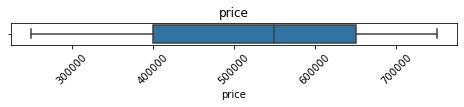

In [109]:
boxplot(df_beta, 'price') # диаграмма размаха

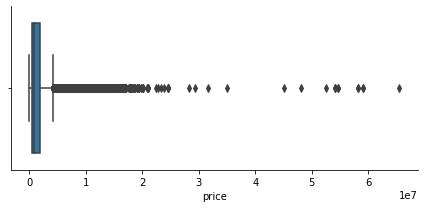

In [110]:
sns.catplot(x="price", kind="box", data=df_beta, height=3, aspect=2)

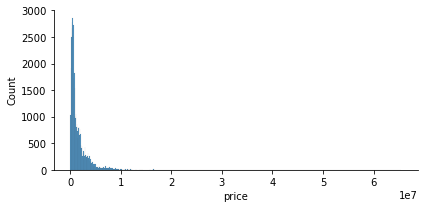

In [111]:
sns.displot(df_beta, x="price", kind="hist", height=3, aspect=2)

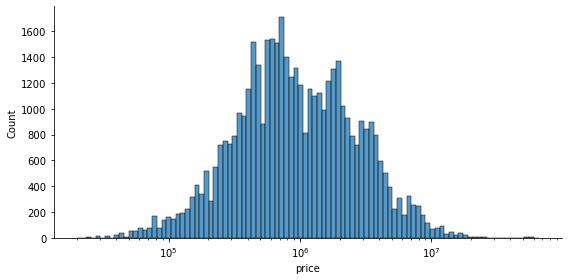

In [112]:
sns.displot(df_beta, x="price", kind="hist", height=4, aspect=2, 
            log_scale=True) # здесь логарифмическая шкала

Распределение похоже на нормальное, но выбросы в зоне сверхбольших цен портят всю картину. При использовании логарифмической шкалы картина более показательна.  
Выбросы - имеется небольшое количество моделей с запредельными запрашивавыми ценами, но их процент невелик и после логарифмирования сильно на модель влиять не будет.

**вывод** - для обучения целевой параметр следует
+ **логарифмировать**
+ или разбить диапазон значений цены на классы пропорционально частоте их распределению в выборке (по их частоте), то есть **кластеризировать** целевую переменную.

#### S03 цвет  

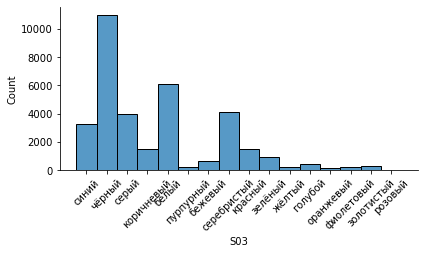

In [113]:
sns.displot(df_alpha, x="S03", kind="hist", height=3, aspect=2)
plt.xticks(rotation=45)
plt.show()

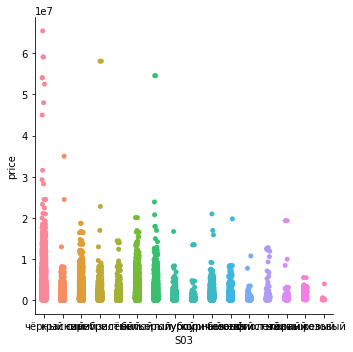

In [114]:
sns.catplot(x="S03", y="price", data=df_beta)

#### S05 мощность  

In [115]:
# df_alpha надо поправить тип данных #129
df_alpha['S05'] = df_alpha['S05'].astype('int64', errors='raise')

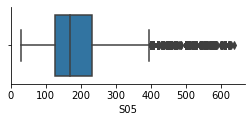

In [116]:
sns.catplot(x="S05", kind="box", data=df_alpha, height=1.8, aspect=2)

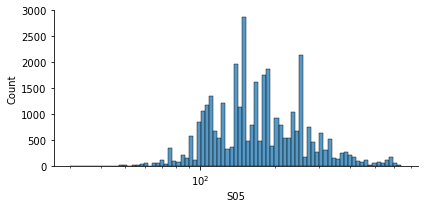

In [117]:
sns.displot(df_alpha, x="S05", kind="hist", height=3, aspect=2, 
            log_scale=True) # здесь логарифмическая шкала

распределение похоже на 'price' - **надо логарифмировать или разбивать на классы прапорционально частоте встречаемости**

<AxesSubplot:xlabel='S05', ylabel='price'>

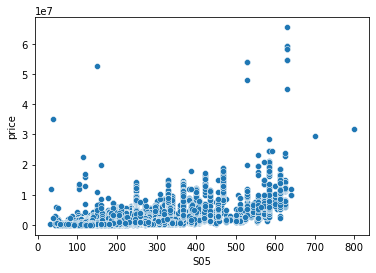

In [118]:
sns.scatterplot(data=df_beta, x="S05", y="price") # влияние на цену

#### S07 пробег

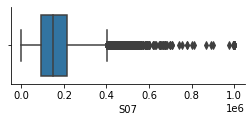

In [119]:
sns.catplot(x="S07", kind="box", data=df_alpha, height=1.8, aspect=2)

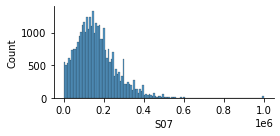

In [120]:
sns.displot(df_alpha, x="S07", kind="hist", height=2, aspect=2)

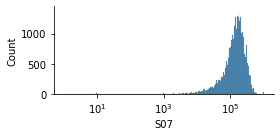

In [121]:
sns.displot(df_alpha, x="S07", kind="hist", height=2, aspect=2, 
            log_scale=True) # здесь логарифмическая шкала

<AxesSubplot:xlabel='S07', ylabel='price'>

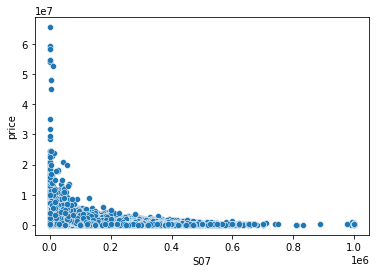

In [122]:
sns.scatterplot(data=df_beta, x="S07", y="price") # влияние на цену

вывод - ничего не делать (или разбивать на классы)

#### S10 число дверей

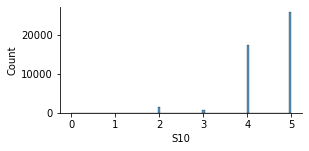

In [123]:
sns.displot(df_beta, x="S10", kind="hist", height=2.2, aspect=2)

In [124]:
df_beta.S10.value_counts(normalize=True)

5.0    0.570558
4.0    0.382226
2.0    0.031189
3.0    0.016005
0.0    0.000022
Name: S10, dtype: float64

<AxesSubplot:xlabel='S10', ylabel='price'>

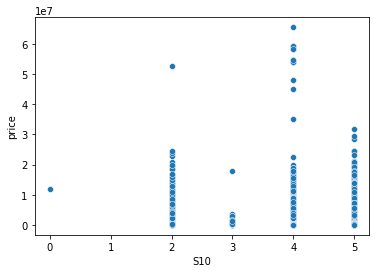

In [125]:
sns.scatterplot(data=df_beta, x="S10", y="price")

выводы - число дверей  4 и 5 = 95% объявлений, 3 двери и 0 дверей - экзотика < 0.02%. наболее дорогие модели тоже в категории 4 и 5. 
попытаемся учесть при категоризации. `as_ordered()` - order 4 > 5 > 2 > 3

#### S14 число владельцев

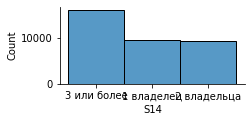

In [126]:
sns.displot(df_alpha, x="S14", kind="hist", height=1.8, aspect=2)

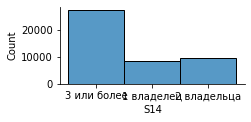

In [127]:
sns.displot(df_beta, x="S14", kind="hist", height=1.8, aspect=2)

по этому признаку обучающий набор более разбалансирован чем тестовый

#### 2 признака про возраст авто: S08 'модельный год' и S11 'год выпуска'

номера календаных годов преобразуем в разницу между ними и 2020 годом (год сбора данных). Полученный возраст авто увеличиваем на 1 для корректного последующего вычисления годового пробега

In [128]:
# значение столбца преобразуем в разницу между ним и 2020 #130
df_alpha['S08'] = 2020 - df_alpha['S08'] 
df_beta['S08'] = 2020 - df_beta['S08']
df_alpha['S11'] = 2020 + 1 - df_alpha['S11']
df_beta['S11'] = 2020 + 1 - df_beta['S11']

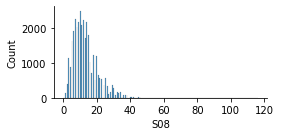

In [129]:
sns.displot(df_alpha, x="S08", kind="hist", height=2, aspect=2) # мод.год

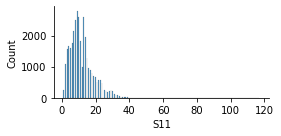

In [130]:
sns.displot(df_alpha, x="S11", kind="hist", height=2, aspect=2) # возраст

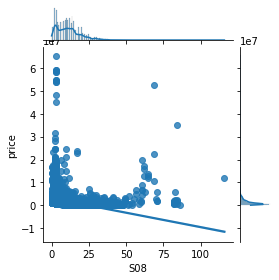

In [131]:
sns.jointplot(x="S08", y="price", 
              height=4, ratio=5, dropna=True, data=df_beta, kind='reg', )

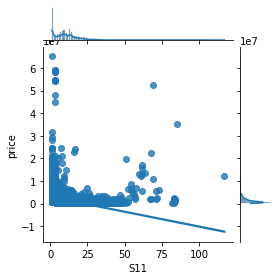

In [132]:
sns.jointplot(x="S11", y="price", 
              height=4, dropna=True, data=df_beta, kind='reg', )

вывод - признаки дублируют друг друга, уточним при корреляционнм анализе

<a name="corr"></a> 
#### корреляционный анализ количественных столбцов

In [133]:
# сгрупируем колонки ПО ТИПУ ДАННЫХ
# количественные (числовые):
num_cols = ['S05', 'S07', 'S08', 'S11',  'S10']
# номинативные бинарные:
bin_cols = ['S15', 'S16',  'S17', 'S21']
# категориальные (номинативные не бинарные):
cat_cols = ['S01', 'S02', 'S03', 'S06', 'S14']
# все категориальные (cat + bin):
cat_cols2 = ['S01', 'S02', 'S03', 'S06', 'S14', 'S15', 'S16',  'S17', 'S21']

In [134]:
df_m = df_beta.corr(method ='spearman') # для ТРЕЙНА
df_m.style.background_gradient(cmap='rainbow').set_precision(2).set_caption('method Spearman')

C:\Users\stoch\AppData\Local\Temp/ipykernel_16556/1110518333.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_m.style.background_gradient(cmap='rainbow').set_precision(2).set_caption('method Spearman')


,price,S05,S07,S08,S10,S11,S21,S22
price,1.00,0.57,-0.78,-0.84,0.26,-0.84,0.15,-0.23
S05,0.57,1.00,-0.18,-0.24,0.11,-0.20,-0.04,-0.09
S07,-0.78,-0.18,1.00,0.85,-0.20,0.87,-0.21,0.22
S08,-0.84,-0.24,0.85,1.00,-0.24,0.98,-0.20,0.22
S10,0.26,0.11,-0.20,-0.24,1.00,-0.25,0.09,-0.07
S11,-0.84,-0.20,0.87,0.98,-0.25,1.00,-0.22,0.23
S21,0.15,-0.04,-0.21,-0.20,0.09,-0.22,1.00,-0.18
S22,-0.23,-0.09,0.22,0.22,-0.07,0.23,-0.18,1.00


Трейн. Ничего неожиданного. Естественная корреляцию между модельным годом S08 и годом выпуска S11.  

Подтверждает большое влияние на цену:
+ мощности S05
+ пробега S07 
+ модельного года S08 
+ и года выпуска S11

Чем **выше** значение f-статистики, тем меньше вероятность того, что средние значения не отличаются, важно для линейной модели.

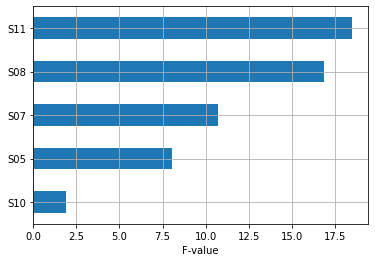

In [135]:
# ANOVA F-test
from sklearn.feature_selection import f_classif, mutual_info_classif, mutual_info_regression
imp_num = pd.Series(f_classif(df_beta[num_cols], df_beta['price'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh',grid=True)
plt.xlabel('F-value')
plt.show()

F-test тоже подтверждает большое влияние на цену:
+ мощности S05
+ пробега S07 
+ модельного года S08 
+ и года выпуска S11

In [136]:
# корреляции посмотрим и в ТЕСТЕ:
df_num = df_alpha[num_cols] 
df_m = df_num.corr(method ='spearman')
df_m.round(2)

,S05,S07,S08,S11,S10
S05,1.00,-0.18,-0.25,-0.21,0.04
S07,-0.18,1.00,0.74,0.76,-0.11
S08,-0.25,0.74,1.00,0.97,-0.17
S11,-0.21,0.76,0.97,1.00,-0.18
S10,0.04,-0.11,-0.17,-0.18,1.00


корреляции в тесте аналогичны трейну

<a name="corr2"></a> 
#### Т-тест  для категориальных признаков

In [137]:
# Т-тест для номинативных столбцов
from itertools import combinations
from scipy.stats import ttest_ind

def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price']
                    ).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки = ', 
                  column)
            break
df = df_beta
for col in cat_cols:   
    get_stat_dif(col)     

Найдены статистически значимые различия для колонки =  S01
Найдены статистически значимые различия для колонки =  S02
Найдены статистически значимые различия для колонки =  S03
Найдены статистически значимые различия для колонки =  S06
Найдены статистически значимые различия для колонки =  S14


большое влияние на цену оказывают:
+ тип авто S01
+ марка авто S02
+ цвет S03
+ тип топлива S06
+ число владельцев S14

<a name="cat_weight"></a> 
#### оценка значимости категоральных признаков   
с помощью функции **mutual_info_classif**  
"relies on nonparametric methods based on entropy estimation from **k-nearest neighbors** distances"  
n_neighbors=3 (default) 

**не смог провести - по непонятной причине вылетает ошибка**  
`ValueError: could not convert string to float: 'полный'`

----------------<<<<<<  >>>>>>-------------

<a name="bis"></a> 
#### вычисление point biserial correlation coefficient

In [138]:
from scipy import stats
def bs_cor(col):  # point biserial correlation
    df_temp = df_beta[['price', col]].copy()
    df_temp.dropna(inplace=True)
    df_temp.iloc[:, 1] = pd.Categorical(df_temp.iloc[:, 1])
    df_temp.iloc[:, 1] = pd.factorize(df_temp.iloc[:, 1], sort=True)[0]
    bs = stats.pointbiserialr(df_temp.iloc[:, 1], df_temp['price'])
    bsc = bs.correlation.round(3)
    print(col, bsc)

In [139]:
for x in cat_cols2:
    bs_cor(x)

S01 -0.278
S02 -0.158
S03 0.071
S06 0.25
S14 0.025
S15 0.296
S16 0.148
S17 -0.099
S21 0.048


наибольшая корреляция с целевым признаком у:
+ тип авто S01
+ тип топлива S06
+ привод S15
+ марка авто S02
+ ПТС S16

при этом методе корреляция с цветом S03 небольшая

<a name="eda1"></a> 
### промежуточные итоги осмотра и подготовки  данных    

In [140]:
# 15 columns:
C01 = 'S01', 'bodyType', 24, 23, '- cat type Ok'
C02 = 'S02', 'brand', 12, 12, '- cat type Ok'
C03 = 'S03', 'color', 16, 16, '- cat type - reduce to 3-4 classes'
C04 = 'S04', 'description' '- if string contain "срочно"' 
C05 = 'S05', 'power', '315', '315', '- convert to cat type, # classes?'
C06 = 'S06', 'fuel', 5, 5, '- cat type Ok'
C07 = 'S07', 'mileage', '', '', '- convert to cat type, # classes?'
C08 = 'S08', 'modelDate', 66, 69, '- convert to cat type, # classes?'

C10 = 'S10', 'doors', 5, 5, '- cat type Ok, reduce to 3 classes?'
C11 = 'S11', 'productionlDate', 69, 72, '- convert to cat type, # classes?'

C13 = 'S13', 'vehicleTransmission', 4, 4, '- cat type Ok'
C14 = 'S14', 'владельцы', 3, 3, '- cat type Ok'
C15 = 'S15', 'привод', 3, 3, '- cat type Ok'
C16 = 'S16', 'ПТС', 2, 2, '- cat type Ok'
C17 = 'S17', 'руль', 2, 2, '- cat type Ok'
C21 = 'S21', 'признак оптовика', 2, 2, '- cat type Ok'
# последние колонки в обоих df: 'sell_id' / 'price'

преобразовываем в категориальный тип готовые столбцы:  
S01, S02, S03, S06, S10, S13, S14, S15, S16, S17, S21, S22

In [141]:
# df_alpha, df_beta - convert to 'category' columns #131
to_conv_list = ['S01', 'S02', 'S03', 'S06', 'S10', 
           'S13', 'S14', 'S15', 'S16', 'S17', 'S21', 'S22']
for col in to_conv_list:
    df_alpha[col] = df_alpha[col].astype('category', errors='raise')
    df_beta[col] = df_beta[col].astype('category', errors='raise')
df_alpha[to_conv_list] = df_alpha[to_conv_list].apply(lambda x: x.cat.codes)
df_beta[to_conv_list] = df_beta[to_conv_list].apply(lambda x: x.cat.codes)

<a name="fe"></a> 
#### Feature Engineering

Два признака уже создали: S21 - флаг оптовика и S22 - 'торг'.  
Создадим ещё пару S30 и S31 - количество слов в описании 'description'и его логарифм.
Создал признак аналогичный "торг" - по содержанию слова "срочно",  
но потом отказался от него поскольку в обучающем наборе при фильтрации признака "срочно" отбирались те же записи, что и при фильтре "торг" (хотя в тестовой базе было совсем иначе - записи "торг" и "срочно" не пересекались, что странно)

Хорошо бы впоследствии преобразовать в категории и количественные признаки (мощность S05 , пробег S07, возраст S08 и S11, price) - т.е. "старше 3 лет" и т.п.  Выделять коллекицонный "антквариат" смысла нет - старше 60 лет всего порядка 30-40 машин.  
Надо каким-то образом определить  эффективное число категорий (классов) для количественных - видимо позднее если хватит времени.  

Пока ограничимся созданием "годового пробега" S23, его логарифма S24, логарифма от "мощности" S25 и логарифмированием целевой переменной 'price_log'.

In [142]:
# S23 - новый признак - годовой пробег - rounded #132
df_alpha['S23'] = (df_alpha['S07'] / df_alpha['S11']).apply(lambda x: round(x))
df_beta['S23'] = (df_beta['S07'] / df_beta['S11']).apply(lambda x: round(x))

# S24 - новый признак - логаримфм годового пробега #133
df_alpha['S24'] = np.log2(df_alpha['S23'] + 1)
df_beta['S24'] = np.log2(df_beta['S23'] + 1)

# S25 - новый признак - натуральный логаримфм мощности #134
df_alpha['S25'] = np.log2(df_alpha['S05'] + 1)
df_beta['S25'] = np.log2(df_beta['S05'] + 1)

# создадим новую колонку - число слов 'S30' #135
df_alpha['S30'] = df_alpha['S04'].str.count(" ")
df_beta['S30'] = df_beta['S04'].str.count(" ")

# создадим новую колонку - логарифм числа слов 'S31' #136
df_alpha['S31'] = np.log2(df_alpha['S30'] + 1)
df_beta['S31'] = np.log2(df_beta['S30'] + 1)

In [143]:
# еще раз убираем ненужные колонки из обоих df # 137
df_alpha = df_alpha.drop(['S04'], axis='columns') # for NLP later?
df_beta = df_beta.drop(['S04'], axis='columns') # for NLP later?
df_alpha = df_alpha.drop(['S09'], axis='columns')
df_beta = df_beta.drop(['S09'], axis='columns')
df_alpha = df_alpha.drop(['S12'], axis='columns')
df_beta = df_beta.drop(['S12'], axis='columns')
df_alpha.reset_index(drop=True, inplace=True);
df_beta.reset_index(drop=True, inplace=True);

In [144]:
# перемещаем ключевые колонки в конец датафрейма #138
df_alpha= df_alpha[
    [col for col in df_alpha.columns if col != 'sell_id'] + ['sell_id']]
df_beta= df_beta[
    [col for col in df_beta.columns if col != 'price'] + ['price']]

In [145]:
# на  всякий случай index reset #139
df_alpha.reset_index(drop=True, inplace=True);
df_beta.reset_index(drop=True, inplace=True);

In [146]:
# выгрузка датасета для ML #140
df_alpha.to_csv("alpha_200.csv", index=False)
df_beta.to_csv("beta_200.csv", index=False)
# итого 22 колонки, df_alpha 34686 entries, df_beta 45112 entries

<a name="final_df"></a> 
### итоговые датасеты
(названия колонок в них одинаковые, кроме последних - 'sell_id' и 'price')

|поле |значение        |количество уникальных|
|-----|----------------|---------------------|
|S01	|тип авто	|24|
|S02	|производитель	|12|
|S03	|цвет	|16|
|S05	|мощность	|314|
|S06	|топливо	|5|
|S07	|пробег	|> 10тыс|
|S08	|модельный возраст	|69|
|S10	|двери	|5|
|S11	|возраст авто	|72|
|S13	|КПП	|4|
|S14	|владельцы|	3|
|S15	|привод	|3|
|S16	|ПТС	|2|
|S17	|руль	|2|
|S21	|"оптовик"	|2|
|S22	|"торг"	|2|
|S23	|годовой пробег| |	
|S24	|лог годового пробега	| |
|S25	|лог мощности	| |
|S30	|число слов| 1179|	
|S31	|лог числа слов	| |
|price	|price	| |

<a name="end_data"></a> 
### на этом процесс подготовки данных завершен  
**продолжение** (вторая часть - ML) - в ноутбуке 'dmar_car_part2.ipinb'  
#### [back to TOP](#top)   

<a name="code"></a>  
### all code in one block

In [147]:
assert False

AssertionError: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def display_all(df):     # display many columns / raws
   with pd.option_context('display.max_rows', 6): # number of rows
      with pd.option_context('display.max_columns', 35): # columns
          display(df)

def col_info(df, col):  # records, NaN, unique, duplicates
    print("всего записей в столбце ", col, " = ", 
          df[col].count())
    print("NaN в столбце ",  col, " = ", df[col].isna().sum(), 
          ",  в процентах = ", 
          "{0:.0%}".format(df[col].isna().sum() / len(df)))
    print("уникальных в столбце ", col, " = ", 
          df[col].nunique(dropna=False))
    
    a = df[df[col].duplicated(keep=False)].count()[1]    
    print("всего записей-дубликатов в столбце ", col, " = ", a)
    
    display_all(pd.DataFrame(df[col].value_counts(sort=True, dropna=False)))

def col_info2(df1, df2, col):  # unique compare
    print("df1 - записей в столбце ", col, " = ", 
          df1[col].count())
    print("df2 - записей в столбце ", col, " = ", 
          df2[col].count())
    print("df1 - уникальных в столбце ", col, " = ", 
          df1[col].nunique(dropna=False))
    print("df2 - уникальных в столбце ", col, " = ", 
          df2[col].nunique(dropna=False))

def col_info3 (df1, df2, col):  # col statistics for two df  
    d = df1[col].describe().round(2).to_list()
    u = df1[col].nunique()
    print('df1', col, ':', u,'unique,', d[3], 'min, ',
          d[7], 'max,', d[1], 'mean,', d[0], 'rows')
    d2 = df2[col].describe().round(2).to_list()
    u2 = df2[col].nunique()
    print('df2', col, ':', u2,'unique,', d2[3], 'min, ',
          d2[7], 'max,', d2[1], 'mean,', d2[0], 'rows')
def nan_columns(df): # наличие пропусков в всем датафрейме
    nan_sum = df.isnull().sum()
    print('NaN fix is needed for columns:', nan_sum[nan_sum > 0], sep='\n'*2)
    
def info_table(df): # таблица NaN и unique по столбцам
    mv = df.isnull().sum()
    mvp = 100 * df.isnull().sum() / len(df)
    mv2 = df.nunique(dropna=False)
    mv_table = pd.concat([mv, mvp, mv2], axis=1)
    mv_table2 = mv_table.rename(columns = {0: 'NaN', 1: '% NaN', 2: 'uniq'})
    mv_table2 = mv_table2[mv_table2.iloc[:,1] >= 0].round(1)
    return mv_table2

def dubl(df): # наличие дубликатов записей в датафрейме
    if len(df) > len(df.drop_duplicates()):
        print('ЕСТЬ ДУБЛИКАТЫ')
        display_all(df[df.duplicated(keep=False)])
    else:
        print('дубликатов нет')

def dubl_col(df, col): # dupl find & show in specific COLUMN
    df2 = df.sort_values(by=[col]) # new dataframe sorted by col
    display_all(df2[df2[col].duplicated(keep=False)]) # show
    
def rename_columns(df): # to standart: from'S00' to 'Sxx'
    df.set_axis(["S"+str(i).zfill(2) for i in range(0, df.shape[1])], 
                 axis=1, inplace=True)
    # print(df.info())

def percentile(df, col): # перцентили, интерквартильный размах
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print(col, ': уровень 25%: {:,},'.format(perc25),
          'уровень 75%: {:,},'.format(perc75), 
          'IQR: {:,}'.format(IQR))    
def boxplot(df, col): # диаграмма размаха (boxplot)
    fig, ax = plt.subplots(figsize = (8, 0.4))
    sns.boxplot(x=col, 
                data=df.loc[
                    df.loc[:, col].isin(df.loc[
                        :, col].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title(col)
    plt.show()

In [ ]:
# грузим входные файлы #101
df_sub = pd.read_csv('empty_submission.csv')
df_alpha = pd.read_csv('test.csv')
df_beta = pd.read_csv('all_auto_ru_09_09_2020.csv')
# названия столбцов - в нижний регистр #102
df_alpha.columns = df_alpha.columns.str.lower()
df_beta.columns = df_beta.columns.str.lower()
# убираем дубликаты из обучающего #103
df_beta.drop_duplicates(keep='first', inplace=True)
# df_alpha - осмотр данных и чистка
# df_alpha - удаляем 8 полей #104
df_alpha.drop(df_alpha.columns[[2, 4, 8, 10, 17, 18, 26, 30, 31]], 
              axis = 1, inplace = True)
# df_beta - осмотр данных
# df_beta - удалим строку "универсал" в столбце 'fueltype' #104
df_beta.drop(df_beta[df_beta.fueltype == 'универсал'].index, inplace=True)
df_beta = df_beta.reset_index(drop=True)
# df_beta - убираем шесть колонок #105
df_beta.drop(df_beta.columns[[14, 17, 20, 21, 24, 25]], 
              axis = 1, inplace = True)
# df_beta - удаляем 410 записей, где отсутствует значение цены #106
df_beta = df_beta[df_beta.price.notna()]
# df_beta -'владельцы' NaN -> 3.0,format as in 'df_alpha' #107
df_beta[df_beta.columns.to_list()[16]].replace(
    to_replace = [1.0, 2.0, 3.0, np.nan], 
    value = ['1 владелец', '2 владельца', '3 или более', '3 или более'],
    inplace = True)
# сравниваем форматы данных в df_alpha и df_beta
# df_beta - 'bodytype'к одинаковому формату название столбца #108
df_beta['bodytype'] = df_beta['bodytype'].str.lower()

In [ ]:
# используем вариант без использования функции
# 1 выбрасываем строки с категориями которых нет в тесте #109
# rows before =  86853 , rows after =  83174 = всё Ок
df_beta.reset_index(drop=True, inplace=True);
u_list = df_alpha["bodytype"].unique().tolist()
before = df_beta.shape[0]
df_beta = df_beta.loc[df_beta["bodytype"].isin(u_list)]
after = len(df_beta)
df_beta.reset_index(drop=True, inplace=True);
print('rows before = ', before, ', rows after = ', after)
# 2 выбрасываем строки с категориями которых нет в тесте #110
df_beta.reset_index(drop=True, inplace=True);
u_list = df_alpha["brand"].unique().tolist()
before = df_beta.shape[0]
df_beta = df_beta.loc[df_beta["brand"].isin(u_list)]
after = len(df_beta)
df_beta.reset_index(drop=True, inplace=True);
print('rows before = ', before, ', rows after = ', after)
# rows before =  83174 , rows after =  45112 = все Ок

In [ ]:
# df_beta - приводим к одинаковому формату поле 'color' #111
c_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 
              'CACECB': 'серебристый', '0000CC': 'синий', 
              '200204': 'коричневый', 'EE1D19': 'красный',  
              '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', 
              '660099': 'пурпурный', 'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}
df_beta["color"].replace(to_replace = c_dict, inplace = True)

# df_alpha, df_beta - убираем столбец 'enginedisplacement' #112
df_alpha = df_alpha.drop(['enginedisplacement'], axis='columns')
df_beta = df_beta.drop(['enginedisplacement'], axis='columns')
# df_alpha - приводим к одинаковому формату 'enginepower' #113
df_alpha['enginepower'] = df_alpha['enginepower'].str.replace(' N12', "")
# df_alpha - убираем ненужные колонки #114
df_alpha = df_alpha.drop(['model_info'], axis='columns')
df_alpha = df_alpha.drop(['model_name'], axis='columns')
df_alpha = df_alpha.drop(['super_gen'], axis='columns')
df_alpha = df_alpha.drop(['vendor'], axis='columns')
df_beta = df_beta.drop(['start_date'], axis='columns')
# df_beta 'vehicletransmission' - приводим к одному формату #115
tr_dic = {'AUTOMATIC': 'автоматическая', 'MECHANICAL': 'механическая',
        'VARIATOR': 'вариатор', 'ROBOT': 'роботизированная'}
df_beta['vehicletransmission'].replace(to_replace = tr_dic, inplace = True)
# df_beta 'ПТС' - all NaN's added to 'DUPLICATE' categoty #116
df_beta[df_beta.columns.to_list()[16]].replace(
    to_replace = [np.nan], 
    value = ["DUPLICATE"],
    inplace = True)
# df_beta 'руль' приводим к одинаковому формату as in 'df_alpha' #117
df_beta[df_beta.columns.to_list()[16]].replace(
    to_replace = ["ORIGINAL", "DUPLICATE"], 
    value = ["Оригинал", "Дубликат"],
    inplace = True)
# df_beta 'руль' к одинаковому формату as in 'df_alpha' #118
df_beta[df_beta.columns.to_list()[14]].replace(
    to_replace = ["LEFT", "RIGHT"], 
    value = ["Левый", "Правый"],
    inplace = True)

In [ ]:
# df_alpha, df_beta - сортируем и переименовываем колонки
# переупорядочим и переименуем колонки
# rename key columns to be the first after index sorting #119
df_alpha.rename(
    columns={'sell_id': 'aa_sell_id'}, inplace=True, errors="raise")
df_beta.rename(
    columns={'price': 'aa_price'}, inplace=True, errors="raise")
# re-order columns #120
df_alpha.sort_index(axis =1, ascending = True, inplace= True)
df_alpha.reset_index(drop=True, inplace=True);
df_beta.sort_index(axis =1, ascending = True, inplace= True)
df_beta.reset_index(drop=True, inplace=True);
# rename column names to standart form (from'S00' to 'Sxx') #121
rename_columns(df_alpha)
rename_columns(df_beta)
# возвращаем оригинальные названия ключевым столбцам #122
df_alpha.rename(columns={'S00': 'sell_id'}, inplace=True, errors="raise")
df_beta.rename(columns={'S00': 'price'}, inplace=True, errors="raise")

In [ ]:
# создаем новый признак S21- оптовый продавец #123
df_alpha['S21'] = df_alpha.duplicated(subset=['S04']).astype('uint8')
df_beta['S21'] = df_beta.duplicated(subset=['S04']).astype('uint8')
# 124 - was moved to end
# df_alpha, df_beta - S04 - замена NaN на "" #125
df_alpha['S04'].fillna("", inplace=True)
df_beta['S04'].fillna("", inplace=True)
# df_alpha - S16 'ПТС' - NaN заменим на 'Дубликат' #126
df_alpha['S16'].fillna("Дубликат", inplace=True)

In [ ]:
# создадим новую колонку "торг" - S22 #127 - ЕСТЬ
df_alpha['S22'] = df_alpha['S04'].str.contains('торг', case=False)
df_beta['S22'] = df_beta['S04'].str.contains('торг', case=False)

In [ ]:
# df_alpha S05 - поправим тип данных #129
df_alpha['S05'] = df_alpha['S05'].astype('int64', errors='raise')

In [ ]:
# значение столбца преобразуем в разницу между ним и 2020 #130
df_alpha['S08'] = 2020 - df_alpha['S08'] 
df_beta['S08'] = 2020 - df_beta['S08']
df_alpha['S11'] = 2020 + 1 - df_alpha['S11']
df_beta['S11'] = 2020 + 1 - df_beta['S11']
#корреляционный анализ количественных столбцов

In [ ]:
# df_alpha, df_beta - convert to 'category' columns #131
to_conv_list = ['S01', 'S02', 'S03', 'S06', 'S10', 
           'S13', 'S14', 'S15', 'S16', 'S17', 'S21', 'S22']
for col in to_conv_list:
    df_alpha[col] = df_alpha[col].astype('category', errors='raise')
    df_beta[col] = df_beta[col].astype('category', errors='raise')
df_alpha[to_conv_list] = df_alpha[to_conv_list].apply(lambda x: x.cat.codes)
df_beta[to_conv_list] = df_beta[to_conv_list].apply(lambda x: x.cat.codes)

In [ ]:
# S23 - новый признак - годовой пробег - rounded #132
df_alpha['S23'] = (df_alpha['S07'] / df_alpha['S11']).apply(lambda x: round(x))
df_beta['S23'] = (df_beta['S07'] / df_beta['S11']).apply(lambda x: round(x))
# S24 - новый признак - логаримфм годового пробега #133
df_alpha['S24'] = np.log2(df_alpha['S23'] + 1)
df_beta['S24'] = np.log2(df_beta['S23'] + 1)
# S25 - новый признак - натуральный логаримфм мощности #134
df_alpha['S25'] = np.log2(df_alpha['S05'] + 1)
df_beta['S25'] = np.log2(df_beta['S05'] + 1)
# создадим новую колонку - число слов 'S30' #135
df_alpha['S30'] = df_alpha['S04'].str.count(" ")
df_beta['S30'] = df_beta['S04'].str.count(" ")
# создадим новую колонку - логарифм числа слов 'S31' #136
df_alpha['S31'] = np.log2(df_alpha['S30'] + 1)
df_beta['S31'] = np.log2(df_beta['S30'] + 1)

In [ ]:
# еще раз убираем ненужные колонки из обоих df # 137
df_alpha = df_alpha.drop(['S04'], axis='columns') # for NLP later?
df_beta = df_beta.drop(['S04'], axis='columns') # for NLP later?
df_alpha = df_alpha.drop(['S09'], axis='columns')
df_beta = df_beta.drop(['S09'], axis='columns')
df_alpha = df_alpha.drop(['S12'], axis='columns')
df_beta = df_beta.drop(['S12'], axis='columns')
df_alpha.reset_index(drop=True, inplace=True);
df_beta.reset_index(drop=True, inplace=True);

In [ ]:
# перемещаем ключевые колонки в конец датафрейма #138
df_alpha= df_alpha[
    [col for col in df_alpha.columns if col != 'sell_id'] + ['sell_id']]
df_beta= df_beta[
    [col for col in df_beta.columns if col != 'price'] + ['price']]

In [ ]:
# на  всякий случай index reset #139
df_alpha.reset_index(drop=True, inplace=True);
df_beta.reset_index(drop=True, inplace=True);

In [ ]:
# выгрузка датасета для ML #140
df_alpha.to_csv("alpha_200.csv", index=False)
df_beta.to_csv("beta_200.csv", index=False)
# итого 22 колонки, df_alpha 34686 entries, df_beta 45112 entries

<a name="top"></a>  
**Навигация:**  
<a href='#task'>задача и метрика  
<a href='#par'>почему без парсинга  
<a href='#setup2'>setup  
<a href='#input'>исходные данные  
<a href='#test_check'>просмотр аттестующего (тестового) набора `df_alpha`  
<a href='#test_clean'>`df_alpha` (тест) - выводы и чистка  
<a href='#df_a_check'>просмотр обучающего `df_beta` (из all_auto_ru_09_09_2020.csv)  
<a href='#df_a_clean'>обучающий набор - `df_beta`- выводы и чистка  
<a href='#compare_df'>сравниваем форматы данных и убираем лишние столбцы и категории  
<a href='#col_sort'>сортируем столбцы  
<a href='#eda'>начало EDA  
<a href='#fields_list'>первичный список типов данных в столбцах  
<a href='#target'>целевая переменная и количественные признаки - ГРАФИКИ  
<a href='#corr'>корреляционный анализ количественных столбцов  
<a href='#corr2'>Т-тест  для категориальных признаков  
<a href='#bis'>point biserial correlation coefficient  
<a href='#eda1'>промежуточные итоги осмотра и подготовки данных  
<a href='#fe'>Feature Engineering  
<a href='#final_df'>итоговые датасеты  
<a href='#end_data'>конец EDA  
<a href='#code'>all code in one block  
<a href='#end'>END

<a name="end"></a>  
### END
## [back to TOP](#top)   